# Apply AI Superresolution to video - Train VDSR from Video Frames



 

# Get a video dataset to do better training
- higher resolution than used in research

### super 8 look https://www.youtube.com/watch?v=7Q5UZmwxIXo
- low focus (diffusion and blur - bokah)
- low contrast
- camera is more shakey on home movies
- high depth of field everything is sharp
- 4x3
- film grain
- color changes
- mpeg2 compression noise

### VCR look
- jitter on scan lines - see http://www.avisynth.nl/users/vcmohan/DeJitter/DeJitter.htm
- chroma issues https://forum.videohelp.com/threads/397928-Imrpove-old-video-recorded-by-a-bad-camera?s=0a1230911434e7442d05b6b6cee8e6d2

- jpeg compression artifacts

## use images of related material to train superres
- family photos to train for family videos
- need water and outdoors
- use video samples for video
- use film examples for super8

## Data Augmentation
- sample a few frames from a few places
- different blur levels- complete
- convolution with disk - complete
- left-right flip - complete
- contrast and brightness - complete
- random crop
- crop to the super8 resolution 720x480 or video 320x240
- GAN statistics
- predict level of blur with same network to encourage differentiation to that
- input of a filter that detects light reflections to help infer blurring
- try mixup
- use a single shot classifier output as an input


## Optimization
- Use Adam
- Use optimal learning rate
- freeze layers
- dropout
- use fp16 - pytorch1.6 has a new library for this - complete

## losses
- try l1 loss
- try perceptive loss vgg18

## do comparisons for standard test sets
- not super useful since they use gaussian blurring, bicubic interpolation



In [1]:
# preprocess video from wmv to mp4

In [2]:
#!ffmpeg -i '/home/filip/Videos/1987 first video making muffins.wmv'  -c:v libx264 -crf 23 -c:a aac -strict -2 -q:a 100 '/media/SSD/superres/1987 first video making muffins.mp4'

In [3]:
#!python /media/SSD/superres/Zooming-Slow-Mo-CVPR-2020/codes/video_to_zsm.py --video /media/SSD/superres/snip.mp4  --model /media/SSD/superres/model/xiang2020zooming.pth --output /media/SSD/superres/muffins_test.mp4


In [4]:
#preprocess from mpeg2 (DVD) to mp4 with antialiasing and only 120 seconds:
#ffmpeg -i 'Old 8mm Reels_1.VOB' -t 120  -vf "bwdif" -c:v libx264 -crf 28 -c:a aac -b:a 128k  'Old 8mm Reels_1.mp4'

In [5]:
!pwd

/media/SSD/superres


To deinterlace
https://video.stackexchange.com/questions/17396/how-to-deinterlacing-with-ffmpeg
https://macilatthefront.blogspot.com/2017/04/deinterlacing-hd-footage-without-losing.html


In [6]:

#%reload_ext autoreload
#%autoreload 2
#%matplotlib inline


import cv2 
import os
import numpy as np
import subprocess as sp
import time
from tqdm import tqdm, trange
from pathlib import Path
import torch
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


import sys
sys.path.insert(0, '/media/SSD/superres/pytorch-vdsr/')

#from vdsr import Net

In [7]:
torch.cuda.manual_seed(42)

Create a data loader
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data.py
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data_utils.py

In [8]:
import torch.utils.data as data

from os import listdir
from os.path import join
from PIL import Image, ImageFilter
import numpy as np
import torchvision as vision


toPIL = vision.transforms.ToPILImage()


def noisy(img, std=3.0):
    mean = 0.0
    gauss = np.random.normal(mean, std, (img.height, img.width, 3))
    # noisy = np.clip(np.uint8(img + gauss), 0, 255)
    noisy = np.uint8(img + gauss)
    return noisy


def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg"])



In [118]:
def is_video_file(path, extensions = ("mp4",)):
    return path.lower().endswith(extensions)

def frame_sampler1(length, frame_sample_size):

    # calculate middle of video and take 'frame_sample_size' frames from middle
    middle = length // 2
    left_length = frame_sample_size//2
    right_length = frame_sample_size - left_length
    left = max(0,middle - left_length)
    right = min(length, middle + right_length)
          
    return list(range(left,right))



def frame_sampler2(length, frame_sample_size):
    return np.linspace(0, length, 3+min(frame_sample_size,length)).astype(int)[2:-1]


# Make this load still photos too, and have them added with frame = 0
def make_framelist(video_dir,frame_sample_size = 10):
    instances = []
    for filename in listdir(video_dir):
        filepath = os.path.join(video_dir,filename)
        #print(filename)
        
        if is_video_file(filepath):
            # open video file
            cap = cv2.VideoCapture(str(filepath))

            # get frame count
            length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

            cap.release()
            
            if frame_sample_size is not None:
                samples = frame_sampler2(length, frame_sample_size)
                # append fn and frame num to instances
            else:
                samples = range(0,length)
                
            for frame in samples:
                item = {"Filepath":filepath,"Type":"frame",  "Framenum":frame}
                instances.append(item)
                
        elif is_image_file(filepath):
            # open image file
            img = cv2.imread(filepath)
            item = {"Filepath":filepath, "Type":"image"}
            instances.append(item)
            
    return instances
        

1

In [128]:
# get a list of all the data
instances = make_framelist("/media/SSD/superres/video_data",1)

In [129]:
instances

[{'Filepath': '/media/SSD/superres/video_data/101890319.mp4',
  'Type': 'frame',
  'Framenum': 3431},
 {'Filepath': '/media/SSD/superres/video_data/107132164.mp4',
  'Type': 'frame',
  'Framenum': 1634},
 {'Filepath': '/media/SSD/superres/video_data/104453980.mp4',
  'Type': 'frame',
  'Framenum': 15060},
 {'Filepath': '/media/SSD/superres/video_data/103604430.mp4',
  'Type': 'frame',
  'Framenum': 5538},
 {'Filepath': '/media/SSD/superres/video_data/110371795.mp4',
  'Type': 'frame',
  'Framenum': 744},
 {'Filepath': '/media/SSD/superres/video_data/101224055.mp4',
  'Type': 'frame',
  'Framenum': 3954},
 {'Filepath': '/media/SSD/superres/video_data/101094248.mp4',
  'Type': 'frame',
  'Framenum': 3290},
 {'Filepath': '/media/SSD/superres/video_data/106501635.mp4',
  'Type': 'frame',
  'Framenum': 1580},
 {'Filepath': '/media/SSD/superres/video_data/102797996.mp4',
  'Type': 'frame',
  'Framenum': 542},
 {'Filepath': '/media/SSD/superres/video_data/114651311.mp4',
  'Type': 'frame',
  

In [130]:
def load_frame(instance):
    
    path = instance["Filepath"]
    
    if instance["Type"] == "frame":
        
        frame = instance["Framenum"]
        cap = cv2.VideoCapture(path)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame-1)
        ret, img = cap.read()
        if ret==0:
            print("Error with:",instance)
    elif instance["Type"] == "image":
        img = cv2.imread(path)
    # convert to PIL RGB
    im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return Image.fromarray(im_rgb)



In [9]:
import numbers

class RescaleCrop(object):


    def __init__(self, crop_size ,kernel_width):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.kernel_width = kernel_width
        

    
        

    def __call__(self, img):
        
        
        # Ideal steps
        # Crop with proportional scale, to simulate images of different input resolutions (if thats a requirement)
        # This crop should leave some edges of the image to allow blurring with kernel beyond final size
        # Blur the image 
        # If different randomly picked blurring kernels are used, they should have equivalent blurring power.
        
        h_size,v_size = img.size
        
        #print("im size:", img.size)
        
        # Resize down to a size a bit larger than final size to allow proper blurring
        v_wanted = int(self.crop_size[0]+2*self.kernel_width+2)
        h_wanted = int(self.crop_size[1]+2*self.kernel_width+2)
        
        #print("im wanted:", (h_wanted, v_wanted))
        
        h_scale = h_wanted/h_size
        v_scale = v_wanted/v_size
        
        scale = max(h_scale, v_scale)
        
        #print("scales=",(h_scale, v_scale))
        
        #print("new size=",(int(h_size*scale), int(v_size*scale)))
        img = img.resize((int(h_size*scale), int(v_size*scale)))
        
        img = CenterCrop((v_wanted,h_wanted))(img) 

        
        return img

In [247]:
from torchvision.transforms import RandomHorizontalFlip,ColorJitter

class DatasetFromVideoFolder(data.Dataset):
    def __init__(self, video_dir,size,frame_sample_size=None, input_transform=None, target_transform=None, add_noise=None, noise_std=3.0, Flip_hor=False,Rand_bright_contrast=False, kernel_width=10):
        super(DatasetFromVideoFolder, self).__init__()
        self.video_frames = make_framelist(video_dir,frame_sample_size)

        self.input_transform = input_transform
        self.target_transform = target_transform
        self.add_noise = add_noise
        self.noise_std = noise_std
        self.Flip_hor = Flip_hor
        self.Rand_bright_contrast = Rand_bright_contrast
        self.size = size
        self.kernel_width = kernel_width

    def __getitem__(self, index):
        input = load_frame(self.video_frames[index])
        
        input = RescaleCrop(self.size,self.kernel_width )(input)
        
        if self.Flip_hor:
            input = RandomHorizontalFlip()(input)
        
        if self.Rand_bright_contrast:
            input = ColorJitter(brightness=.2, contrast=.2)(input)
        
        
        target = input.copy()
        if self.input_transform:
            if self.add_noise:
                input = noisy(input, self.noise_std)
                input = toPIL(input)
            input = self.input_transform(input)
        if self.target_transform:
            target = self.target_transform(target)

        return input, target

    def __len__(self):
        return len(self.video_frames)

In [10]:
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize, Grayscale

In [11]:
import random
from astropy.convolution import  Gaussian2DKernel, Tophat2DKernel,AiryDisk2DKernel

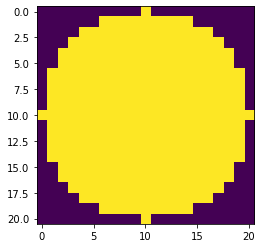

In [250]:
plt.imshow(Tophat2DKernel(10).array)

In [12]:
import numbers
def cv_center_crop(img,output_size):
        if isinstance(output_size, numbers.Number):
            output_size = (int(output_size), int(output_size))
            
        
        image_height = img.shape[0]
        image_width = img.shape[1]
        
        crop_height, crop_width = output_size
        crop_top = max(0,int(round((image_height - crop_height) / 2.)))
        crop_left = max(0,int(round((image_width - crop_width) / 2.)))
        #print("input:",img.shape)
        #print("output:",output_size)
        #print("crop:",crop_top,crop_top+output_size[0],crop_left,crop_left+output_size[1])
        return img[crop_top:crop_top+output_size[0],crop_left:crop_left+output_size[1]]

In [13]:
import random

class CropRescale(object):


    def __init__(self, crop_size ,factor_range):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.factor_range = factor_range
        

    
        

    def __call__(self, img):
        
        rand_scale_factor = random.uniform(*self.factor_range)
        #print("size of image",img.size)
        
        # Ideal steps
        # Crop with proportional scale, to simulate images of different input resolutions (if thats a requirement)
        # This crop should leave some edges of the image to allow blurring with kernel beyond final size
        # Blur the image 
        # If different randomly picked blurring kernels are used, they should have equivalent blurring power.
        
        h_size,v_size = img.size
        
        #print("im size:", img.size)
        
        # Resize down to a size a bit larger than final size to allow proper blurring
        v_wanted = int(self.crop_size[0]+2*rand_scale_factor+2)
        h_wanted = int(self.crop_size[1]+2*rand_scale_factor+2)
        
        #print("im wanted:", (h_wanted, v_wanted))
        
        h_scale = h_wanted/h_size
        v_scale = v_wanted/v_size
        
        scale = max(h_scale, v_scale)
        
        #print("scales=",(h_scale, v_scale))
        
        #print("new size=",(int(h_size*scale), int(v_size*scale)))
        img = img.resize((int(h_size*scale), int(v_size*scale)))
        
        img_cv = cv_center_crop(np.array(img),(v_wanted,h_wanted))  

        
        #Disk Blur
        #print(max(np.array(img)), min(np.array(img)))
        img_cv = cv2.filter2D(img_cv, -1, Tophat2DKernel(rand_scale_factor).array)
    
        #Center Crop
        img_cv = cv_center_crop(img_cv,self.crop_size)
        
        #Jpeg compression (for adding artifacts)
        #rand_quality_factor = random.uniform(30,90)
        #is_success, im_buf_arr = cv2.imencode(".jpg", img_cv,params = [cv2.IMWRITE_JPEG_QUALITY,30])
        #img_cv = cv2.imdecode(im_buf_arr,flags=cv2.IMREAD_COLOR)
        
        
        img= Image.fromarray(img_cv)
        return img

In [20]:
class Crappify(object):


    def __init__(self, crop_size ,factor_range):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.factor_range = factor_range
        

    
        

    def __call__(self, img):
        
        rand_scale_factor = random.uniform(*self.factor_range)
        
        img_cv = np.array(img)

        
        #Disk Blur
        #print(max(np.array(img)), min(np.array(img)))
        img_cv = cv2.filter2D(img_cv, -1, Tophat2DKernel(rand_scale_factor).array)
    
        #Center Crop
        img_cv = cv_center_crop(img_cv,self.crop_size)
        
        #Jpeg compression (for adding artifacts)
        rand_quality_factor = random.uniform(30,90)
        is_success, im_buf_arr = cv2.imencode(".jpg", img_cv,params = [cv2.IMWRITE_JPEG_QUALITY,30])
        img_cv = cv2.imdecode(im_buf_arr,flags=cv2.IMREAD_COLOR)
        
        
        img= Image.fromarray(img_cv)
        return img

(1280, 720) (720, 480)


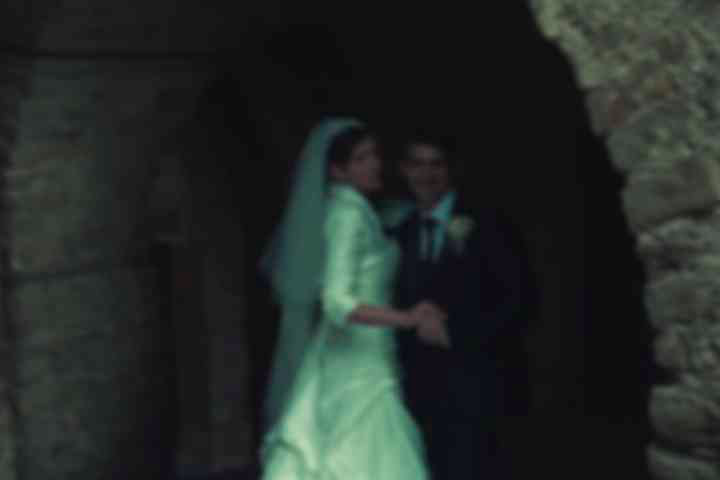

In [254]:
#test the CropRescale transform
im=load_frame(instances[5])
#im = Grayscale(num_output_channels=1)(im)
im_res = RescaleCrop(crop_size = (480,720), kernel_width=10)(im)
im_res = Crappify(crop_size = (480,720), factor_range=(2,8))(im_res)
print(im.size,im_res.size)
type(im_res)
im_res

In [255]:
#

In [256]:
instances[19]

{'Filepath': '/media/SSD/superres/video_data/DSC00862.jpg', 'Type': 'image'}

(256, 256) (256, 256)


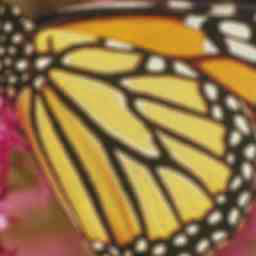

In [257]:
im_gt = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT.bmp").convert("RGB")
#im_gt = Image.open("/home/filip/Pictures/Screenshot from CADDX000009.MP4.png").convert("RGB")
im_res = CropRescale(crop_size = 256, factor_range=(4,4))(im_gt)
print(im_gt.size,im_res.size)
type(im_res)
im_res

In [285]:


def input_transform(crop_size, factor_range):
    
    
    return Compose([
        
        Crappify(crop_size,factor_range), 
        Grayscale(num_output_channels=1),
        ToTensor(),
    ])



def target_transform(crop_size):
    print(crop_size)
    return Compose([
        Grayscale(num_output_channels=1),
        CenterCrop(crop_size),
        ToTensor(),
    ])


def get_training_set(data_dir, crop_size, upscale_factor, frame_sample_size=10, add_noise=None, 
                     noise_std=3.0,Flip_hor=True,Rand_bright_contrast=True):
    

    cropsize = crop_size
    return DatasetFromVideoFolder(data_dir,crop_size, frame_sample_size,
                             input_transform=input_transform(
                                 crop_size, upscale_factor),
                             target_transform=target_transform(crop_size),
                             add_noise=add_noise,
                             noise_std=noise_std,Flip_hor=Flip_hor,
                             Rand_bright_contrast=Rand_bright_contrast)


## Below functions need work

def get_validation_set(data_dir, crop_size, upscale_factor):
    
    
    return DatasetFromVideoFolder(data_dir,frame_sample_size,
                             input_transform=input_transform(
                                 cropsize, upscale_factor,frame_sample_size=10),
                             target_transform=target_transform(cropsize))


def get_test_set(data_dir, crop_size, upscale_factor):


    return DatasetFromVideoFolder(data_dir,frame_sample_size=None,
                             input_transform=input_transform(
                                 cropsize, upscale_factor),
                             target_transform=target_transform(cropsize))

In [286]:
train_dir = "/media/SSD/superres/video_data"
frame_sample_size =10
batch_size = 4 # For FP16, 480x720 size images
crop_size = (480,720)
upscale_factor=(2,6)
add_noise=False
noise_std=3.0
Flip_hor=True
Rand_bright_contrast=True

In [287]:
train_set = get_training_set(data_dir=train_dir, crop_size=crop_size,
            upscale_factor=upscale_factor,frame_sample_size =frame_sample_size, 
            add_noise=add_noise, noise_std=noise_std,Flip_hor=Flip_hor,Rand_bright_contrast=Rand_bright_contrast)
training_data_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=batch_size, shuffle=True)

(480, 720)


In [14]:
# measurement of blur of an image
def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

In [289]:

def show_batch(dataloader,size = 8):

    inputs, outputs = next(iter(dataloader))
    inputs = inputs.numpy().transpose((0, 2, 3, 1))
    outputs = outputs.numpy().transpose((0, 2, 3, 1))
    
    
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inputs = inputs*std + mean
    #outputs = outputs*std + mean
    w,h = 2*size, 4*size
    fig=plt.figure(figsize=(w, h))
    columns = 2
    rows = 4
    ax=[]
    
    for i in range(0, rows):
        blur_measure_input = variance_of_laplacian((inputs[i]*255).astype(np.uint8))
        blur_measure_output = variance_of_laplacian((outputs[i]*255).astype(np.uint8))
        ax.append(fig.add_subplot(rows, columns, 2*i+1))
        ax[-1].set_title('Blur: '+str(blur_measure_input))
        plt.imshow((inputs[i]*255).astype(np.uint8),cmap='gray')
        ax.append(fig.add_subplot(rows, columns, 2*i+2))
        ax[-1].set_title('Blur: '+str(blur_measure_output))
        plt.imshow((outputs[i]*255).astype(np.uint8),cmap='gray')
    plt.show()

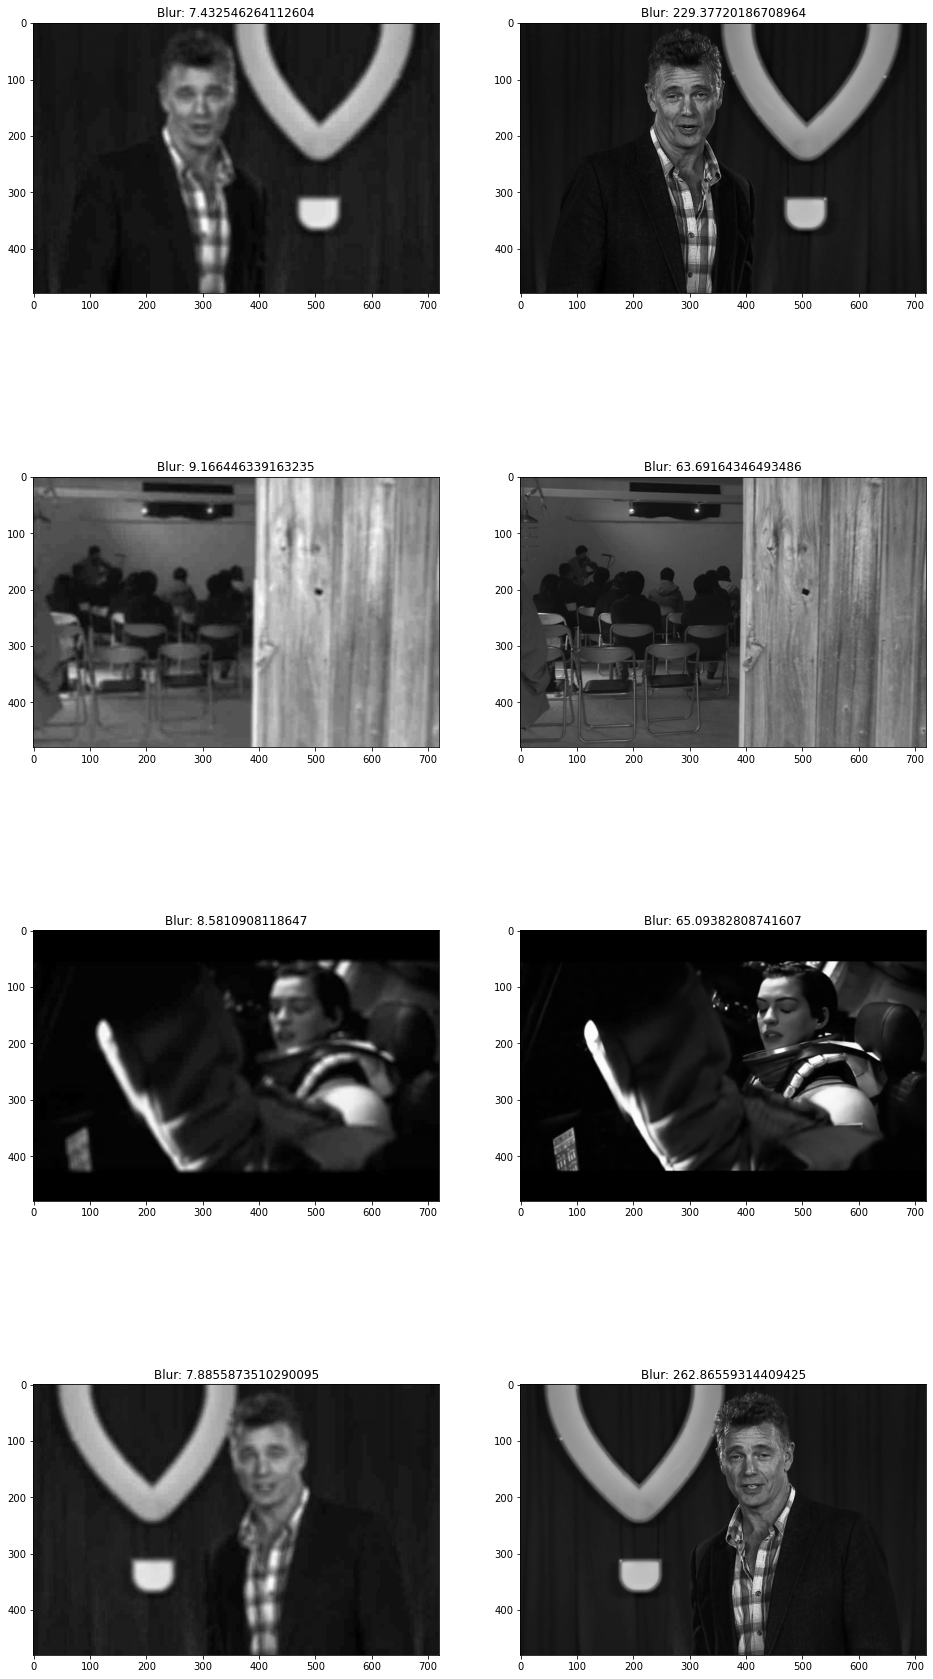

In [290]:
show_batch(training_data_loader,size =8)

# VDSR with dropout

In [25]:
import torch.nn as nn
from math import sqrt

class Conv_ReLU_Block(nn.Module):
    def __init__(self):
        super(Conv_ReLU_Block, self).__init__()
        self.conv = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.do = nn.Dropout2d(p=0.5, inplace=True)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        return self.relu(self.conv(x))
        
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.residual_layer = self.make_layer(Conv_ReLU_Block, 18)
        self.input = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.output = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
    
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, sqrt(2. / n))
                
    def make_layer(self, block, num_of_layer):
        layers = []
        for _ in range(num_of_layer):
            layers.append(block())
        return nn.Sequential(*layers)

    def forward(self, x):
        residual = x
        out = self.relu(self.input(x))
        out = self.residual_layer(out)
        out = self.output(out)
        out = torch.add(out,residual)
        return out

# Build the model

In [26]:
model = Net()
model.cuda()


Net(
  (residual_layer): Sequential(
    (0): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (do): Dropout2d(p=0.5, inplace=True)
      (relu): ReLU(inplace=True)
    )
    (1): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (do): Dropout2d(p=0.5, inplace=True)
      (relu): ReLU(inplace=True)
    )
    (2): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (do): Dropout2d(p=0.5, inplace=True)
      (relu): ReLU(inplace=True)
    )
    (3): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (do): Dropout2d(p=0.5, inplace=True)
      (relu): ReLU(inplace=True)
    )
    (4): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (do): Dropout2d(p=0.5, inplace=True)
  

In [274]:
model = torch.load("/media/SSD/superres/pytorch-vdsr/model/model_epoch_50.pth")["model"]



/media/SSD/conda_env/superres/lib/python3.8/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/media/SSD/conda_env/superres/lib/python3.8/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/media/SSD/conda_env/superres/lib/python3.8/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original sourc

In [ ]:
model

In [275]:
criterion = nn.MSELoss(reduction = 'sum')
#criterion = nn.L1Loss(reduction = 'sum')

In [276]:
init_lr = 0.1/100
lr_step = 3
gradient_clip = 0.4
epochs = 20

In [277]:
#optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=0.9, weight_decay=1e-4)
optimizer = optim.Adam(model.parameters(), lr=init_lr, weight_decay=1e-4)

In [278]:
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 
                                          max_lr=0.01,
                                          steps_per_epoch=len(training_data_loader),
                                          epochs=epochs)

In [279]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 10 epochs"""
    lr = init_lr * (0.1 ** (.5*(epoch // lr_step)))
    return lr

In [280]:
def save_checkpoint(model, epoch):
    model_out_path = "checkpoint/" + "model5_epoch_{}.pth".format(epoch)
    state = {"epoch": epoch ,"model": model}
    if not os.path.exists("checkpoint/"):
        os.makedirs("checkpoint/")

    torch.save(state, model_out_path)

    print("Checkpoint saved to {}".format(model_out_path))

In [ ]:
def train(training_data_loader, optimizer, model, criterion, epoch):
    lr = adjust_learning_rate(optimizer, epoch-1)

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

    print("Epoch = {}, lr = {}".format(epoch, optimizer.param_groups[0]["lr"]))

    model.train()

    for iteration, batch in enumerate(training_data_loader, 1):
        input, target = Variable(batch[0]), Variable(batch[1], requires_grad=False)

        
        input = input.cuda()
        target = target.cuda()

        loss = criterion(model(input), target)
        optimizer.zero_grad()
        loss.backward() 
        nn.utils.clip_grad_norm_(model.parameters(),gradient_clip) 
        optimizer.step()

        if iteration%10 == 0:
            dt = str(datetime.datetime.now())
            print("===> Time: {} Epoch[{}]({}/{}): Loss: {:.10f}".format(dt,epoch, iteration, len(training_data_loader), loss.data))

In [281]:
import datetime
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler

In [282]:
def trainfp16(training_data_loader, optimizer, scheduler, model, criterion, epoch,scaler):
    lr = adjust_learning_rate(optimizer, epoch-1)

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

    print("Epoch = {}, lr = {}".format(epoch, optimizer.param_groups[0]["lr"]))

    model.train()
    
    cum_loss = 0
    ct=0

    for iteration, batch in enumerate(training_data_loader, 1):
        input, target = Variable(batch[0]), Variable(batch[1], requires_grad=False)

        
        input = input.cuda()
        target = target.cuda()
        
        # Runs the forward pass with autocasting.
        with autocast():
            loss = criterion(model(input), target)
            
        
        optimizer.zero_grad()
        
        scaler.scale(loss).backward()
        #loss.backward() 
        
        # Unscales the gradients of optimizer's assigned params in-place
        scaler.unscale_(optimizer)
        
        nn.utils.clip_grad_norm_(model.parameters(),gradient_clip) 
        
        #optimizer.step()
        scaler.step(optimizer)
        
        # Updates the scale for next iteration.
        scaler.update()
        
        #scheduler.step()
        
        cum_loss = cum_loss + loss.data
        ct = ct +batch_size
        

        if iteration%10 == 0:
            dt = str(datetime.datetime.now())
            print("===> Time: {} Epoch[{}]({}/{}): LR: {} : Loss: {:.10f}".format(dt,epoch, iteration, len(training_data_loader), optimizer.param_groups[0]["lr"], cum_loss/ct))
            ct=0
            cum_loss =0
            

In [291]:
# Creates a GradScaler once at the beginning of training for mixed precision
scaler = GradScaler()

for epoch in range(1, epochs+1):
        trainfp16(training_data_loader, optimizer, scheduler, model, criterion, epoch,scaler)
        save_checkpoint(model, epoch)

Epoch = 1, lr = 0.001
===> Time: 2020-09-16 22:31:43.721241 Epoch[1](10/1586): LR: 0.001 : Loss: 976.6646728516
===> Time: 2020-09-16 22:31:53.549369 Epoch[1](20/1586): LR: 0.001 : Loss: 42466.0390625000
===> Time: 2020-09-16 22:32:03.609095 Epoch[1](30/1586): LR: 0.001 : Loss: 53413.7500000000
===> Time: 2020-09-16 22:32:13.387298 Epoch[1](40/1586): LR: 0.001 : Loss: 1141.9029541016
===> Time: 2020-09-16 22:32:23.249969 Epoch[1](50/1586): LR: 0.001 : Loss: 1003.9088745117
===> Time: 2020-09-16 22:32:32.874879 Epoch[1](60/1586): LR: 0.001 : Loss: 1297.3127441406
===> Time: 2020-09-16 22:32:42.882155 Epoch[1](70/1586): LR: 0.001 : Loss: 862.4918823242
===> Time: 2020-09-16 22:32:52.958710 Epoch[1](80/1586): LR: 0.001 : Loss: 1113.2615966797
===> Time: 2020-09-16 22:33:02.988601 Epoch[1](90/1586): LR: 0.001 : Loss: 954.3938598633
===> Time: 2020-09-16 22:33:12.928129 Epoch[1](100/1586): LR: 0.001 : Loss: 825.8283081055
===> Time: 2020-09-16 22:33:22.751256 Epoch[1](110/1586): LR: 0.001 :

===> Time: 2020-09-16 22:46:26.579230 Epoch[1](910/1586): LR: 0.001 : Loss: 883.4350585938
===> Time: 2020-09-16 22:46:36.234764 Epoch[1](920/1586): LR: 0.001 : Loss: 793.6420898438
===> Time: 2020-09-16 22:46:45.928372 Epoch[1](930/1586): LR: 0.001 : Loss: 1228.1295166016
===> Time: 2020-09-16 22:46:55.541574 Epoch[1](940/1586): LR: 0.001 : Loss: 750.0364379883
===> Time: 2020-09-16 22:47:05.175305 Epoch[1](950/1586): LR: 0.001 : Loss: 661.2948608398
===> Time: 2020-09-16 22:47:14.900538 Epoch[1](960/1586): LR: 0.001 : Loss: 644.4270629883
===> Time: 2020-09-16 22:47:24.455278 Epoch[1](970/1586): LR: 0.001 : Loss: 1090.0911865234
===> Time: 2020-09-16 22:47:34.252291 Epoch[1](980/1586): LR: 0.001 : Loss: 809.6829833984
===> Time: 2020-09-16 22:47:44.017546 Epoch[1](990/1586): LR: 0.001 : Loss: 964.0523681641
===> Time: 2020-09-16 22:47:53.647802 Epoch[1](1000/1586): LR: 0.001 : Loss: 1084.4454345703
===> Time: 2020-09-16 22:48:03.293362 Epoch[1](1010/1586): LR: 0.001 : Loss: 808.25610

===> Time: 2020-09-16 23:00:52.765328 Epoch[2](220/1586): LR: 0.001 : Loss: 1021.1196289062
===> Time: 2020-09-16 23:01:02.349218 Epoch[2](230/1586): LR: 0.001 : Loss: 801.1660766602
===> Time: 2020-09-16 23:01:12.105036 Epoch[2](240/1586): LR: 0.001 : Loss: 808.3553466797
===> Time: 2020-09-16 23:01:21.717050 Epoch[2](250/1586): LR: 0.001 : Loss: 721.5392456055
===> Time: 2020-09-16 23:01:31.542355 Epoch[2](260/1586): LR: 0.001 : Loss: 760.6548461914
===> Time: 2020-09-16 23:01:41.330834 Epoch[2](270/1586): LR: 0.001 : Loss: 720.7198486328
===> Time: 2020-09-16 23:01:50.934505 Epoch[2](280/1586): LR: 0.001 : Loss: 771.0346069336
===> Time: 2020-09-16 23:02:00.563343 Epoch[2](290/1586): LR: 0.001 : Loss: 751.7954711914
===> Time: 2020-09-16 23:02:10.320241 Epoch[2](300/1586): LR: 0.001 : Loss: 1054.2708740234
===> Time: 2020-09-16 23:02:19.852882 Epoch[2](310/1586): LR: 0.001 : Loss: 893.0009765625
===> Time: 2020-09-16 23:02:29.626801 Epoch[2](320/1586): LR: 0.001 : Loss: 760.93566894

===> Time: 2020-09-16 23:15:20.533578 Epoch[2](1120/1586): LR: 0.001 : Loss: 586.2774658203
===> Time: 2020-09-16 23:15:30.045317 Epoch[2](1130/1586): LR: 0.001 : Loss: 812.9038696289
===> Time: 2020-09-16 23:15:39.529757 Epoch[2](1140/1586): LR: 0.001 : Loss: 855.3659057617
===> Time: 2020-09-16 23:15:49.123194 Epoch[2](1150/1586): LR: 0.001 : Loss: 787.6116333008
===> Time: 2020-09-16 23:15:58.753633 Epoch[2](1160/1586): LR: 0.001 : Loss: 790.7197875977
===> Time: 2020-09-16 23:16:08.333533 Epoch[2](1170/1586): LR: 0.001 : Loss: 798.6038208008
===> Time: 2020-09-16 23:16:18.146689 Epoch[2](1180/1586): LR: 0.001 : Loss: 1215.1730957031
===> Time: 2020-09-16 23:16:27.756118 Epoch[2](1190/1586): LR: 0.001 : Loss: 750.1473999023
===> Time: 2020-09-16 23:16:37.415321 Epoch[2](1200/1586): LR: 0.001 : Loss: 724.3854370117
===> Time: 2020-09-16 23:16:47.086062 Epoch[2](1210/1586): LR: 0.001 : Loss: 1067.3685302734
===> Time: 2020-09-16 23:16:56.851536 Epoch[2](1220/1586): LR: 0.001 : Loss: 9

===> Time: 2020-09-16 23:29:43.401421 Epoch[3](430/1586): LR: 0.001 : Loss: 802.1312866211
===> Time: 2020-09-16 23:29:52.957676 Epoch[3](440/1586): LR: 0.001 : Loss: 779.2437744141
===> Time: 2020-09-16 23:30:02.418079 Epoch[3](450/1586): LR: 0.001 : Loss: 842.9789428711
===> Time: 2020-09-16 23:30:12.014898 Epoch[3](460/1586): LR: 0.001 : Loss: 546.5957641602
===> Time: 2020-09-16 23:30:21.524759 Epoch[3](470/1586): LR: 0.001 : Loss: 647.8062133789
===> Time: 2020-09-16 23:30:31.175760 Epoch[3](480/1586): LR: 0.001 : Loss: 800.6271362305
===> Time: 2020-09-16 23:30:40.753920 Epoch[3](490/1586): LR: 0.001 : Loss: 939.7941284180
===> Time: 2020-09-16 23:30:50.334552 Epoch[3](500/1586): LR: 0.001 : Loss: 686.3479614258
===> Time: 2020-09-16 23:30:59.876636 Epoch[3](510/1586): LR: 0.001 : Loss: 696.8971557617
===> Time: 2020-09-16 23:31:09.514579 Epoch[3](520/1586): LR: 0.001 : Loss: 858.5142822266
===> Time: 2020-09-16 23:31:19.050781 Epoch[3](530/1586): LR: 0.001 : Loss: 982.4219970703

===> Time: 2020-09-16 23:44:07.284704 Epoch[3](1330/1586): LR: 0.001 : Loss: 831.5532226562
===> Time: 2020-09-16 23:44:16.831484 Epoch[3](1340/1586): LR: 0.001 : Loss: 678.1073608398
===> Time: 2020-09-16 23:44:26.331213 Epoch[3](1350/1586): LR: 0.001 : Loss: 654.1029052734
===> Time: 2020-09-16 23:44:35.919932 Epoch[3](1360/1586): LR: 0.001 : Loss: 560.6757202148
===> Time: 2020-09-16 23:44:45.571547 Epoch[3](1370/1586): LR: 0.001 : Loss: 1177.1971435547
===> Time: 2020-09-16 23:44:55.178878 Epoch[3](1380/1586): LR: 0.001 : Loss: 808.1671142578
===> Time: 2020-09-16 23:45:04.922489 Epoch[3](1390/1586): LR: 0.001 : Loss: 697.3836669922
===> Time: 2020-09-16 23:45:14.578631 Epoch[3](1400/1586): LR: 0.001 : Loss: 844.8109741211
===> Time: 2020-09-16 23:45:24.288931 Epoch[3](1410/1586): LR: 0.001 : Loss: 803.1467895508
===> Time: 2020-09-16 23:45:34.009937 Epoch[3](1420/1586): LR: 0.001 : Loss: 943.3843994141
===> Time: 2020-09-16 23:45:43.681991 Epoch[3](1430/1586): LR: 0.001 : Loss: 65

===> Time: 2020-09-16 23:56:51.299764 Epoch[4](540/1586): LR: 0.00031622776601683794 : Loss: 695.9492187500
===> Time: 2020-09-16 23:57:00.945228 Epoch[4](550/1586): LR: 0.00031622776601683794 : Loss: 782.6324462891
===> Time: 2020-09-16 23:57:10.497163 Epoch[4](560/1586): LR: 0.00031622776601683794 : Loss: 509.8202819824
===> Time: 2020-09-16 23:57:20.031881 Epoch[4](570/1586): LR: 0.00031622776601683794 : Loss: 708.1778564453
===> Time: 2020-09-16 23:57:29.646905 Epoch[4](580/1586): LR: 0.00031622776601683794 : Loss: 739.6680908203
===> Time: 2020-09-16 23:57:39.177173 Epoch[4](590/1586): LR: 0.00031622776601683794 : Loss: 783.1867065430
===> Time: 2020-09-16 23:57:48.580006 Epoch[4](600/1586): LR: 0.00031622776601683794 : Loss: 846.6879882812
===> Time: 2020-09-16 23:57:58.103840 Epoch[4](610/1586): LR: 0.00031622776601683794 : Loss: 753.7606811523
===> Time: 2020-09-16 23:58:07.585837 Epoch[4](620/1586): LR: 0.00031622776601683794 : Loss: 902.1308593750
===> Time: 2020-09-16 23:58:

===> Time: 2020-09-17 00:08:57.509854 Epoch[4](1300/1586): LR: 0.00031622776601683794 : Loss: 807.8142700195
===> Time: 2020-09-17 00:09:06.976523 Epoch[4](1310/1586): LR: 0.00031622776601683794 : Loss: 1088.1678466797
===> Time: 2020-09-17 00:09:16.524085 Epoch[4](1320/1586): LR: 0.00031622776601683794 : Loss: 846.1406250000
===> Time: 2020-09-17 00:09:26.067577 Epoch[4](1330/1586): LR: 0.00031622776601683794 : Loss: 1035.6823730469
===> Time: 2020-09-17 00:09:35.719187 Epoch[4](1340/1586): LR: 0.00031622776601683794 : Loss: 718.2616577148
===> Time: 2020-09-17 00:09:45.260065 Epoch[4](1350/1586): LR: 0.00031622776601683794 : Loss: 733.8877563477
===> Time: 2020-09-17 00:09:54.924985 Epoch[4](1360/1586): LR: 0.00031622776601683794 : Loss: 724.3285522461
===> Time: 2020-09-17 00:10:04.615796 Epoch[4](1370/1586): LR: 0.00031622776601683794 : Loss: 892.3493041992
===> Time: 2020-09-17 00:10:14.001585 Epoch[4](1380/1586): LR: 0.00031622776601683794 : Loss: 525.4435424805
===> Time: 2020-0

===> Time: 2020-09-17 00:20:59.798630 Epoch[5](470/1586): LR: 0.00031622776601683794 : Loss: 726.9876098633
===> Time: 2020-09-17 00:21:09.160986 Epoch[5](480/1586): LR: 0.00031622776601683794 : Loss: 697.0612182617
===> Time: 2020-09-17 00:21:18.832913 Epoch[5](490/1586): LR: 0.00031622776601683794 : Loss: 804.0651855469
===> Time: 2020-09-17 00:21:28.386445 Epoch[5](500/1586): LR: 0.00031622776601683794 : Loss: 1011.5222778320
===> Time: 2020-09-17 00:21:37.871599 Epoch[5](510/1586): LR: 0.00031622776601683794 : Loss: 1067.0794677734
===> Time: 2020-09-17 00:21:47.376403 Epoch[5](520/1586): LR: 0.00031622776601683794 : Loss: 843.3192749023
===> Time: 2020-09-17 00:21:56.997634 Epoch[5](530/1586): LR: 0.00031622776601683794 : Loss: 662.4226684570
===> Time: 2020-09-17 00:22:06.331686 Epoch[5](540/1586): LR: 0.00031622776601683794 : Loss: 787.5191650391
===> Time: 2020-09-17 00:22:15.882393 Epoch[5](550/1586): LR: 0.00031622776601683794 : Loss: 1095.4512939453
===> Time: 2020-09-17 00:

===> Time: 2020-09-17 00:33:05.727335 Epoch[5](1230/1586): LR: 0.00031622776601683794 : Loss: 816.7178344727
===> Time: 2020-09-17 00:33:15.441867 Epoch[5](1240/1586): LR: 0.00031622776601683794 : Loss: 755.3012695312
===> Time: 2020-09-17 00:33:25.171438 Epoch[5](1250/1586): LR: 0.00031622776601683794 : Loss: 930.1151733398
===> Time: 2020-09-17 00:33:34.672749 Epoch[5](1260/1586): LR: 0.00031622776601683794 : Loss: 700.4911499023
===> Time: 2020-09-17 00:33:44.321184 Epoch[5](1270/1586): LR: 0.00031622776601683794 : Loss: 637.7465209961
===> Time: 2020-09-17 00:33:53.866257 Epoch[5](1280/1586): LR: 0.00031622776601683794 : Loss: 662.3295288086
===> Time: 2020-09-17 00:34:03.259367 Epoch[5](1290/1586): LR: 0.00031622776601683794 : Loss: 846.9769897461
===> Time: 2020-09-17 00:34:12.893748 Epoch[5](1300/1586): LR: 0.00031622776601683794 : Loss: 907.1396484375
===> Time: 2020-09-17 00:34:22.438353 Epoch[5](1310/1586): LR: 0.00031622776601683794 : Loss: 632.2720947266
===> Time: 2020-09-

===> Time: 2020-09-17 00:45:08.265472 Epoch[6](400/1586): LR: 0.00031622776601683794 : Loss: 540.3973999023
===> Time: 2020-09-17 00:45:17.865146 Epoch[6](410/1586): LR: 0.00031622776601683794 : Loss: 907.6064453125
===> Time: 2020-09-17 00:45:27.596882 Epoch[6](420/1586): LR: 0.00031622776601683794 : Loss: 796.4852905273
===> Time: 2020-09-17 00:45:37.085572 Epoch[6](430/1586): LR: 0.00031622776601683794 : Loss: 736.7955932617
===> Time: 2020-09-17 00:45:46.543222 Epoch[6](440/1586): LR: 0.00031622776601683794 : Loss: 905.2323608398
===> Time: 2020-09-17 00:45:56.194302 Epoch[6](450/1586): LR: 0.00031622776601683794 : Loss: 628.4722290039
===> Time: 2020-09-17 00:46:05.683132 Epoch[6](460/1586): LR: 0.00031622776601683794 : Loss: 681.5982666016
===> Time: 2020-09-17 00:46:15.175767 Epoch[6](470/1586): LR: 0.00031622776601683794 : Loss: 1243.1473388672
===> Time: 2020-09-17 00:46:24.904251 Epoch[6](480/1586): LR: 0.00031622776601683794 : Loss: 952.8759765625
===> Time: 2020-09-17 00:46

===> Time: 2020-09-17 00:57:14.449529 Epoch[6](1160/1586): LR: 0.00031622776601683794 : Loss: 969.6570434570
===> Time: 2020-09-17 00:57:24.061999 Epoch[6](1170/1586): LR: 0.00031622776601683794 : Loss: 804.1113281250
===> Time: 2020-09-17 00:57:33.646526 Epoch[6](1180/1586): LR: 0.00031622776601683794 : Loss: 653.9948120117
===> Time: 2020-09-17 00:57:43.253845 Epoch[6](1190/1586): LR: 0.00031622776601683794 : Loss: 1006.0766601562
===> Time: 2020-09-17 00:57:52.800329 Epoch[6](1200/1586): LR: 0.00031622776601683794 : Loss: 751.8040771484
===> Time: 2020-09-17 00:58:02.231969 Epoch[6](1210/1586): LR: 0.00031622776601683794 : Loss: 651.9818115234
===> Time: 2020-09-17 00:58:11.845261 Epoch[6](1220/1586): LR: 0.00031622776601683794 : Loss: 833.8646850586
===> Time: 2020-09-17 00:58:21.234363 Epoch[6](1230/1586): LR: 0.00031622776601683794 : Loss: 625.8404541016
===> Time: 2020-09-17 00:58:30.870480 Epoch[6](1240/1586): LR: 0.00031622776601683794 : Loss: 1076.1555175781
===> Time: 2020-0

===> Time: 2020-09-17 01:10:16.092246 Epoch[7](390/1586): LR: 0.0001 : Loss: 836.3956298828
===> Time: 2020-09-17 01:10:25.600740 Epoch[7](400/1586): LR: 0.0001 : Loss: 872.6298828125
===> Time: 2020-09-17 01:10:35.244085 Epoch[7](410/1586): LR: 0.0001 : Loss: 820.9091186523
===> Time: 2020-09-17 01:10:44.916693 Epoch[7](420/1586): LR: 0.0001 : Loss: 759.3740234375
===> Time: 2020-09-17 01:10:54.512338 Epoch[7](430/1586): LR: 0.0001 : Loss: 690.8735351562
===> Time: 2020-09-17 01:11:04.341462 Epoch[7](440/1586): LR: 0.0001 : Loss: 864.9833374023
===> Time: 2020-09-17 01:11:13.872259 Epoch[7](450/1586): LR: 0.0001 : Loss: 896.2333374023
===> Time: 2020-09-17 01:11:23.499933 Epoch[7](460/1586): LR: 0.0001 : Loss: 810.1417236328
===> Time: 2020-09-17 01:11:33.132782 Epoch[7](470/1586): LR: 0.0001 : Loss: 910.8541870117
===> Time: 2020-09-17 01:11:42.726087 Epoch[7](480/1586): LR: 0.0001 : Loss: 586.7028808594
===> Time: 2020-09-17 01:11:52.245470 Epoch[7](490/1586): LR: 0.0001 : Loss: 687

===> Time: 2020-09-17 01:24:27.609045 Epoch[7](1280/1586): LR: 0.0001 : Loss: 630.6680908203
===> Time: 2020-09-17 01:24:37.224007 Epoch[7](1290/1586): LR: 0.0001 : Loss: 605.6315917969
===> Time: 2020-09-17 01:24:46.779832 Epoch[7](1300/1586): LR: 0.0001 : Loss: 965.7813720703
===> Time: 2020-09-17 01:24:56.446973 Epoch[7](1310/1586): LR: 0.0001 : Loss: 699.9196166992
===> Time: 2020-09-17 01:25:06.053712 Epoch[7](1320/1586): LR: 0.0001 : Loss: 930.1191406250
===> Time: 2020-09-17 01:25:15.543144 Epoch[7](1330/1586): LR: 0.0001 : Loss: 694.6756591797
===> Time: 2020-09-17 01:25:25.204736 Epoch[7](1340/1586): LR: 0.0001 : Loss: 681.8750000000
===> Time: 2020-09-17 01:25:34.884191 Epoch[7](1350/1586): LR: 0.0001 : Loss: 651.6545410156
===> Time: 2020-09-17 01:25:44.451660 Epoch[7](1360/1586): LR: 0.0001 : Loss: 722.5221557617
===> Time: 2020-09-17 01:25:54.053929 Epoch[7](1370/1586): LR: 0.0001 : Loss: 614.1197509766
===> Time: 2020-09-17 01:26:03.487150 Epoch[7](1380/1586): LR: 0.0001 

===> Time: 2020-09-17 01:38:38.009623 Epoch[8](580/1586): LR: 0.0001 : Loss: 1133.7198486328
===> Time: 2020-09-17 01:38:47.625486 Epoch[8](590/1586): LR: 0.0001 : Loss: 610.8104858398
===> Time: 2020-09-17 01:38:57.132686 Epoch[8](600/1586): LR: 0.0001 : Loss: 941.4151611328
===> Time: 2020-09-17 01:39:06.787006 Epoch[8](610/1586): LR: 0.0001 : Loss: 680.7389526367
===> Time: 2020-09-17 01:39:16.343565 Epoch[8](620/1586): LR: 0.0001 : Loss: 655.3560180664
===> Time: 2020-09-17 01:39:25.817346 Epoch[8](630/1586): LR: 0.0001 : Loss: 1086.5358886719
===> Time: 2020-09-17 01:39:35.543277 Epoch[8](640/1586): LR: 0.0001 : Loss: 560.1937866211
===> Time: 2020-09-17 01:39:45.157663 Epoch[8](650/1586): LR: 0.0001 : Loss: 717.2191772461
===> Time: 2020-09-17 01:39:54.770154 Epoch[8](660/1586): LR: 0.0001 : Loss: 817.9882812500
===> Time: 2020-09-17 01:40:04.581193 Epoch[8](670/1586): LR: 0.0001 : Loss: 730.0821533203
===> Time: 2020-09-17 01:40:14.182487 Epoch[8](680/1586): LR: 0.0001 : Loss: 9

===> Time: 2020-09-17 01:52:49.792921 Epoch[8](1470/1586): LR: 0.0001 : Loss: 583.8463134766
===> Time: 2020-09-17 01:52:59.260316 Epoch[8](1480/1586): LR: 0.0001 : Loss: 890.1825561523
===> Time: 2020-09-17 01:53:08.749757 Epoch[8](1490/1586): LR: 0.0001 : Loss: 520.9728393555
===> Time: 2020-09-17 01:53:18.390815 Epoch[8](1500/1586): LR: 0.0001 : Loss: 858.4120483398
===> Time: 2020-09-17 01:53:27.980667 Epoch[8](1510/1586): LR: 0.0001 : Loss: 1039.1824951172
===> Time: 2020-09-17 01:53:37.530437 Epoch[8](1520/1586): LR: 0.0001 : Loss: 592.0697631836
===> Time: 2020-09-17 01:53:47.093193 Epoch[8](1530/1586): LR: 0.0001 : Loss: 656.0611572266
===> Time: 2020-09-17 01:53:56.856005 Epoch[8](1540/1586): LR: 0.0001 : Loss: 600.7644653320
===> Time: 2020-09-17 01:54:06.388464 Epoch[8](1550/1586): LR: 0.0001 : Loss: 952.3770751953
===> Time: 2020-09-17 01:54:15.960620 Epoch[8](1560/1586): LR: 0.0001 : Loss: 550.1145629883
===> Time: 2020-09-17 01:54:25.578143 Epoch[8](1570/1586): LR: 0.0001

===> Time: 2020-09-17 02:07:08.182030 Epoch[9](780/1586): LR: 0.0001 : Loss: 657.9503784180
===> Time: 2020-09-17 02:07:17.801560 Epoch[9](790/1586): LR: 0.0001 : Loss: 773.4895629883
===> Time: 2020-09-17 02:07:27.347989 Epoch[9](800/1586): LR: 0.0001 : Loss: 718.1640014648
===> Time: 2020-09-17 02:07:36.958705 Epoch[9](810/1586): LR: 0.0001 : Loss: 659.9802856445
===> Time: 2020-09-17 02:07:46.584086 Epoch[9](820/1586): LR: 0.0001 : Loss: 772.3626098633
===> Time: 2020-09-17 02:07:56.159583 Epoch[9](830/1586): LR: 0.0001 : Loss: 619.3092651367
===> Time: 2020-09-17 02:08:05.744649 Epoch[9](840/1586): LR: 0.0001 : Loss: 539.7377319336
===> Time: 2020-09-17 02:08:15.426471 Epoch[9](850/1586): LR: 0.0001 : Loss: 700.6405029297
===> Time: 2020-09-17 02:08:24.930988 Epoch[9](860/1586): LR: 0.0001 : Loss: 817.1747436523
===> Time: 2020-09-17 02:08:34.496222 Epoch[9](870/1586): LR: 0.0001 : Loss: 492.3509826660
===> Time: 2020-09-17 02:08:44.060666 Epoch[9](880/1586): LR: 0.0001 : Loss: 715

===> Time: 2020-09-17 02:21:10.300933 Epoch[10](70/1586): LR: 3.16227766016838e-05 : Loss: 523.1388549805
===> Time: 2020-09-17 02:21:20.005062 Epoch[10](80/1586): LR: 3.16227766016838e-05 : Loss: 837.2543945312
===> Time: 2020-09-17 02:21:29.475957 Epoch[10](90/1586): LR: 3.16227766016838e-05 : Loss: 941.8297119141
===> Time: 2020-09-17 02:21:39.048601 Epoch[10](100/1586): LR: 3.16227766016838e-05 : Loss: 886.3562622070
===> Time: 2020-09-17 02:21:48.793310 Epoch[10](110/1586): LR: 3.16227766016838e-05 : Loss: 662.8781127930
===> Time: 2020-09-17 02:21:58.602016 Epoch[10](120/1586): LR: 3.16227766016838e-05 : Loss: 998.6065673828
===> Time: 2020-09-17 02:22:08.194791 Epoch[10](130/1586): LR: 3.16227766016838e-05 : Loss: 862.3496093750
===> Time: 2020-09-17 02:22:17.766144 Epoch[10](140/1586): LR: 3.16227766016838e-05 : Loss: 609.8197631836
===> Time: 2020-09-17 02:22:27.322852 Epoch[10](150/1586): LR: 3.16227766016838e-05 : Loss: 734.4154663086
===> Time: 2020-09-17 02:22:36.971051 Ep

===> Time: 2020-09-17 02:33:31.693000 Epoch[10](840/1586): LR: 3.16227766016838e-05 : Loss: 526.2352294922
===> Time: 2020-09-17 02:33:41.194953 Epoch[10](850/1586): LR: 3.16227766016838e-05 : Loss: 854.0872192383
===> Time: 2020-09-17 02:33:50.644243 Epoch[10](860/1586): LR: 3.16227766016838e-05 : Loss: 635.1707153320
===> Time: 2020-09-17 02:34:00.219222 Epoch[10](870/1586): LR: 3.16227766016838e-05 : Loss: 954.0690307617
===> Time: 2020-09-17 02:34:09.696006 Epoch[10](880/1586): LR: 3.16227766016838e-05 : Loss: 543.1547241211
===> Time: 2020-09-17 02:34:19.237118 Epoch[10](890/1586): LR: 3.16227766016838e-05 : Loss: 642.2595214844
===> Time: 2020-09-17 02:34:28.813376 Epoch[10](900/1586): LR: 3.16227766016838e-05 : Loss: 829.0957031250
===> Time: 2020-09-17 02:34:38.323993 Epoch[10](910/1586): LR: 3.16227766016838e-05 : Loss: 890.5136718750
===> Time: 2020-09-17 02:34:47.945528 Epoch[10](920/1586): LR: 3.16227766016838e-05 : Loss: 793.5054931641
===> Time: 2020-09-17 02:34:57.292344

===> Time: 2020-09-17 02:45:47.579919 Epoch[11](20/1586): LR: 3.16227766016838e-05 : Loss: 946.9765625000
===> Time: 2020-09-17 02:45:57.129179 Epoch[11](30/1586): LR: 3.16227766016838e-05 : Loss: 700.7548828125
===> Time: 2020-09-17 02:46:06.645257 Epoch[11](40/1586): LR: 3.16227766016838e-05 : Loss: 635.8189697266
===> Time: 2020-09-17 02:46:16.264183 Epoch[11](50/1586): LR: 3.16227766016838e-05 : Loss: 659.1716308594
===> Time: 2020-09-17 02:46:25.842395 Epoch[11](60/1586): LR: 3.16227766016838e-05 : Loss: 695.1950073242
===> Time: 2020-09-17 02:46:35.293099 Epoch[11](70/1586): LR: 3.16227766016838e-05 : Loss: 678.3934936523
===> Time: 2020-09-17 02:46:44.670583 Epoch[11](80/1586): LR: 3.16227766016838e-05 : Loss: 821.9010620117
===> Time: 2020-09-17 02:46:54.114931 Epoch[11](90/1586): LR: 3.16227766016838e-05 : Loss: 675.0380249023
===> Time: 2020-09-17 02:47:03.575373 Epoch[11](100/1586): LR: 3.16227766016838e-05 : Loss: 757.9256591797
===> Time: 2020-09-17 02:47:13.299187 Epoch[1

===> Time: 2020-09-17 02:58:04.850189 Epoch[11](790/1586): LR: 3.16227766016838e-05 : Loss: 459.9205627441
===> Time: 2020-09-17 02:58:14.450292 Epoch[11](800/1586): LR: 3.16227766016838e-05 : Loss: 574.4367675781
===> Time: 2020-09-17 02:58:24.202759 Epoch[11](810/1586): LR: 3.16227766016838e-05 : Loss: 865.0862426758
===> Time: 2020-09-17 02:58:33.687109 Epoch[11](820/1586): LR: 3.16227766016838e-05 : Loss: 924.9970703125
===> Time: 2020-09-17 02:58:43.304772 Epoch[11](830/1586): LR: 3.16227766016838e-05 : Loss: 741.4948730469
===> Time: 2020-09-17 02:58:52.845389 Epoch[11](840/1586): LR: 3.16227766016838e-05 : Loss: 819.4506225586
===> Time: 2020-09-17 02:59:02.474734 Epoch[11](850/1586): LR: 3.16227766016838e-05 : Loss: 854.9252319336
===> Time: 2020-09-17 02:59:12.039523 Epoch[11](860/1586): LR: 3.16227766016838e-05 : Loss: 1022.6875000000
===> Time: 2020-09-17 02:59:21.840481 Epoch[11](870/1586): LR: 3.16227766016838e-05 : Loss: 661.5248413086
===> Time: 2020-09-17 02:59:31.27651

===> Time: 2020-09-17 03:10:15.559152 Epoch[11](1550/1586): LR: 3.16227766016838e-05 : Loss: 849.7983398438
===> Time: 2020-09-17 03:10:25.212762 Epoch[11](1560/1586): LR: 3.16227766016838e-05 : Loss: 702.8124389648
===> Time: 2020-09-17 03:10:34.694734 Epoch[11](1570/1586): LR: 3.16227766016838e-05 : Loss: 639.5690307617
===> Time: 2020-09-17 03:10:44.199174 Epoch[11](1580/1586): LR: 3.16227766016838e-05 : Loss: 727.7151489258
Checkpoint saved to checkpoint/model5_epoch_11.pth
Epoch = 12, lr = 3.16227766016838e-05
===> Time: 2020-09-17 03:10:59.261547 Epoch[12](10/1586): LR: 3.16227766016838e-05 : Loss: 936.4034423828
===> Time: 2020-09-17 03:11:08.950181 Epoch[12](20/1586): LR: 3.16227766016838e-05 : Loss: 887.7416381836
===> Time: 2020-09-17 03:11:18.474562 Epoch[12](30/1586): LR: 3.16227766016838e-05 : Loss: 1013.8554077148
===> Time: 2020-09-17 03:11:28.201316 Epoch[12](40/1586): LR: 3.16227766016838e-05 : Loss: 664.7213745117
===> Time: 2020-09-17 03:11:37.911397 Epoch[12](50/158

===> Time: 2020-09-17 03:22:59.544376 Epoch[12](730/1586): LR: 3.16227766016838e-05 : Loss: 1082.1906738281
===> Time: 2020-09-17 03:23:09.470518 Epoch[12](740/1586): LR: 3.16227766016838e-05 : Loss: 585.5418701172
===> Time: 2020-09-17 03:23:19.485366 Epoch[12](750/1586): LR: 3.16227766016838e-05 : Loss: 486.6524963379
===> Time: 2020-09-17 03:23:29.747387 Epoch[12](760/1586): LR: 3.16227766016838e-05 : Loss: 1184.3786621094
===> Time: 2020-09-17 03:23:39.763429 Epoch[12](770/1586): LR: 3.16227766016838e-05 : Loss: 511.3245239258
===> Time: 2020-09-17 03:23:49.793803 Epoch[12](780/1586): LR: 3.16227766016838e-05 : Loss: 661.0660400391
===> Time: 2020-09-17 03:23:59.922759 Epoch[12](790/1586): LR: 3.16227766016838e-05 : Loss: 659.9856567383
===> Time: 2020-09-17 03:24:09.968889 Epoch[12](800/1586): LR: 3.16227766016838e-05 : Loss: 889.4955444336
===> Time: 2020-09-17 03:24:19.848290 Epoch[12](810/1586): LR: 3.16227766016838e-05 : Loss: 733.1687622070
===> Time: 2020-09-17 03:24:29.9203

===> Time: 2020-09-17 03:35:50.005364 Epoch[12](1500/1586): LR: 3.16227766016838e-05 : Loss: 851.5173950195
===> Time: 2020-09-17 03:36:00.062711 Epoch[12](1510/1586): LR: 3.16227766016838e-05 : Loss: 658.8873901367
===> Time: 2020-09-17 03:36:09.964763 Epoch[12](1520/1586): LR: 3.16227766016838e-05 : Loss: 640.6163940430
===> Time: 2020-09-17 03:36:19.834038 Epoch[12](1530/1586): LR: 3.16227766016838e-05 : Loss: 804.8457031250
===> Time: 2020-09-17 03:36:29.901526 Epoch[12](1540/1586): LR: 3.16227766016838e-05 : Loss: 901.0226440430
===> Time: 2020-09-17 03:36:39.658561 Epoch[12](1550/1586): LR: 3.16227766016838e-05 : Loss: 884.8481445312
===> Time: 2020-09-17 03:36:49.859473 Epoch[12](1560/1586): LR: 3.16227766016838e-05 : Loss: 406.1038513184
===> Time: 2020-09-17 03:36:59.835229 Epoch[12](1570/1586): LR: 3.16227766016838e-05 : Loss: 803.7821655273
===> Time: 2020-09-17 03:37:09.697138 Epoch[12](1580/1586): LR: 3.16227766016838e-05 : Loss: 576.4047241211
Checkpoint saved to checkpoi

===> Time: 2020-09-17 03:47:55.823432 Epoch[13](670/1586): LR: 1.0000000000000003e-05 : Loss: 1316.6811523438
===> Time: 2020-09-17 03:48:05.390480 Epoch[13](680/1586): LR: 1.0000000000000003e-05 : Loss: 706.7354736328
===> Time: 2020-09-17 03:48:15.034744 Epoch[13](690/1586): LR: 1.0000000000000003e-05 : Loss: 673.8245849609
===> Time: 2020-09-17 03:48:24.772059 Epoch[13](700/1586): LR: 1.0000000000000003e-05 : Loss: 1080.9174804688
===> Time: 2020-09-17 03:48:34.145328 Epoch[13](710/1586): LR: 1.0000000000000003e-05 : Loss: 487.9410095215
===> Time: 2020-09-17 03:48:43.671246 Epoch[13](720/1586): LR: 1.0000000000000003e-05 : Loss: 777.0303344727
===> Time: 2020-09-17 03:48:53.197517 Epoch[13](730/1586): LR: 1.0000000000000003e-05 : Loss: 867.4558715820
===> Time: 2020-09-17 03:49:02.775132 Epoch[13](740/1586): LR: 1.0000000000000003e-05 : Loss: 695.0493774414
===> Time: 2020-09-17 03:49:12.473377 Epoch[13](750/1586): LR: 1.0000000000000003e-05 : Loss: 745.1097412109
===> Time: 2020-0

===> Time: 2020-09-17 03:59:52.707409 Epoch[13](1420/1586): LR: 1.0000000000000003e-05 : Loss: 769.3320312500
===> Time: 2020-09-17 04:00:02.176101 Epoch[13](1430/1586): LR: 1.0000000000000003e-05 : Loss: 664.6756591797
===> Time: 2020-09-17 04:00:11.722914 Epoch[13](1440/1586): LR: 1.0000000000000003e-05 : Loss: 709.2944946289
===> Time: 2020-09-17 04:00:21.304556 Epoch[13](1450/1586): LR: 1.0000000000000003e-05 : Loss: 642.9639282227
===> Time: 2020-09-17 04:00:31.011148 Epoch[13](1460/1586): LR: 1.0000000000000003e-05 : Loss: 1024.7850341797
===> Time: 2020-09-17 04:00:40.564751 Epoch[13](1470/1586): LR: 1.0000000000000003e-05 : Loss: 615.0753173828
===> Time: 2020-09-17 04:00:50.096595 Epoch[13](1480/1586): LR: 1.0000000000000003e-05 : Loss: 669.3352050781
===> Time: 2020-09-17 04:00:59.888802 Epoch[13](1490/1586): LR: 1.0000000000000003e-05 : Loss: 963.9370117188
===> Time: 2020-09-17 04:01:09.297925 Epoch[13](1500/1586): LR: 1.0000000000000003e-05 : Loss: 550.5050659180
===> Time

===> Time: 2020-09-17 04:11:54.487036 Epoch[14](590/1586): LR: 1.0000000000000003e-05 : Loss: 964.0827026367
===> Time: 2020-09-17 04:12:03.875557 Epoch[14](600/1586): LR: 1.0000000000000003e-05 : Loss: 608.2116088867
===> Time: 2020-09-17 04:12:13.460839 Epoch[14](610/1586): LR: 1.0000000000000003e-05 : Loss: 685.1936645508
===> Time: 2020-09-17 04:12:22.915311 Epoch[14](620/1586): LR: 1.0000000000000003e-05 : Loss: 764.3557739258
===> Time: 2020-09-17 04:12:32.473139 Epoch[14](630/1586): LR: 1.0000000000000003e-05 : Loss: 678.3598022461
===> Time: 2020-09-17 04:12:42.027285 Epoch[14](640/1586): LR: 1.0000000000000003e-05 : Loss: 872.8017578125
===> Time: 2020-09-17 04:12:51.732351 Epoch[14](650/1586): LR: 1.0000000000000003e-05 : Loss: 826.9306030273
===> Time: 2020-09-17 04:13:01.331998 Epoch[14](660/1586): LR: 1.0000000000000003e-05 : Loss: 744.6790161133
===> Time: 2020-09-17 04:13:10.810210 Epoch[14](670/1586): LR: 1.0000000000000003e-05 : Loss: 611.7677612305
===> Time: 2020-09-

===> Time: 2020-09-17 04:23:50.899176 Epoch[14](1340/1586): LR: 1.0000000000000003e-05 : Loss: 588.3609619141
===> Time: 2020-09-17 04:24:00.572953 Epoch[14](1350/1586): LR: 1.0000000000000003e-05 : Loss: 769.8504638672
===> Time: 2020-09-17 04:24:10.057928 Epoch[14](1360/1586): LR: 1.0000000000000003e-05 : Loss: 1031.1395263672
===> Time: 2020-09-17 04:24:19.634617 Epoch[14](1370/1586): LR: 1.0000000000000003e-05 : Loss: 831.1041259766
===> Time: 2020-09-17 04:24:29.185495 Epoch[14](1380/1586): LR: 1.0000000000000003e-05 : Loss: 614.4850463867
===> Time: 2020-09-17 04:24:38.577006 Epoch[14](1390/1586): LR: 1.0000000000000003e-05 : Loss: 709.5055541992
===> Time: 2020-09-17 04:24:47.952225 Epoch[14](1400/1586): LR: 1.0000000000000003e-05 : Loss: 561.2014770508
===> Time: 2020-09-17 04:24:57.465865 Epoch[14](1410/1586): LR: 1.0000000000000003e-05 : Loss: 552.9357299805
===> Time: 2020-09-17 04:25:07.035246 Epoch[14](1420/1586): LR: 1.0000000000000003e-05 : Loss: 753.0836791992
===> Time

===> Time: 2020-09-17 04:35:51.996802 Epoch[15](510/1586): LR: 1.0000000000000003e-05 : Loss: 768.4023437500
===> Time: 2020-09-17 04:36:01.597764 Epoch[15](520/1586): LR: 1.0000000000000003e-05 : Loss: 697.2103881836
===> Time: 2020-09-17 04:36:11.075610 Epoch[15](530/1586): LR: 1.0000000000000003e-05 : Loss: 870.6718139648
===> Time: 2020-09-17 04:36:20.601021 Epoch[15](540/1586): LR: 1.0000000000000003e-05 : Loss: 650.5548706055
===> Time: 2020-09-17 04:36:30.140591 Epoch[15](550/1586): LR: 1.0000000000000003e-05 : Loss: 632.1830444336
===> Time: 2020-09-17 04:36:39.744429 Epoch[15](560/1586): LR: 1.0000000000000003e-05 : Loss: 577.0255126953
===> Time: 2020-09-17 04:36:49.364902 Epoch[15](570/1586): LR: 1.0000000000000003e-05 : Loss: 613.6239624023
===> Time: 2020-09-17 04:36:58.953678 Epoch[15](580/1586): LR: 1.0000000000000003e-05 : Loss: 872.4273681641
===> Time: 2020-09-17 04:37:08.405482 Epoch[15](590/1586): LR: 1.0000000000000003e-05 : Loss: 725.1764526367
===> Time: 2020-09-

===> Time: 2020-09-17 04:47:49.763477 Epoch[15](1260/1586): LR: 1.0000000000000003e-05 : Loss: 1136.2725830078
===> Time: 2020-09-17 04:47:59.224927 Epoch[15](1270/1586): LR: 1.0000000000000003e-05 : Loss: 736.4349975586
===> Time: 2020-09-17 04:48:08.631762 Epoch[15](1280/1586): LR: 1.0000000000000003e-05 : Loss: 832.8774414062
===> Time: 2020-09-17 04:48:18.070403 Epoch[15](1290/1586): LR: 1.0000000000000003e-05 : Loss: 818.4119873047
===> Time: 2020-09-17 04:48:27.618830 Epoch[15](1300/1586): LR: 1.0000000000000003e-05 : Loss: 730.2957763672
===> Time: 2020-09-17 04:48:37.045918 Epoch[15](1310/1586): LR: 1.0000000000000003e-05 : Loss: 717.6203002930
===> Time: 2020-09-17 04:48:46.478160 Epoch[15](1320/1586): LR: 1.0000000000000003e-05 : Loss: 741.9341430664
===> Time: 2020-09-17 04:48:56.121834 Epoch[15](1330/1586): LR: 1.0000000000000003e-05 : Loss: 785.4249877930
===> Time: 2020-09-17 04:49:05.692642 Epoch[15](1340/1586): LR: 1.0000000000000003e-05 : Loss: 544.2136230469
===> Time

===> Time: 2020-09-17 04:59:55.195461 Epoch[16](430/1586): LR: 3.16227766016838e-06 : Loss: 654.5874023438
===> Time: 2020-09-17 05:00:05.025949 Epoch[16](440/1586): LR: 3.16227766016838e-06 : Loss: 714.7615356445
===> Time: 2020-09-17 05:00:14.744410 Epoch[16](450/1586): LR: 3.16227766016838e-06 : Loss: 577.6732788086
===> Time: 2020-09-17 05:00:24.468547 Epoch[16](460/1586): LR: 3.16227766016838e-06 : Loss: 974.7435913086
===> Time: 2020-09-17 05:00:34.120990 Epoch[16](470/1586): LR: 3.16227766016838e-06 : Loss: 688.1151733398
===> Time: 2020-09-17 05:00:43.542157 Epoch[16](480/1586): LR: 3.16227766016838e-06 : Loss: 674.5698242188
===> Time: 2020-09-17 05:00:53.218066 Epoch[16](490/1586): LR: 3.16227766016838e-06 : Loss: 674.7578125000
===> Time: 2020-09-17 05:01:02.892231 Epoch[16](500/1586): LR: 3.16227766016838e-06 : Loss: 725.3440551758
===> Time: 2020-09-17 05:01:12.444882 Epoch[16](510/1586): LR: 3.16227766016838e-06 : Loss: 747.4651489258
===> Time: 2020-09-17 05:01:22.030948

===> Time: 2020-09-17 05:12:14.440890 Epoch[16](1200/1586): LR: 3.16227766016838e-06 : Loss: 944.0427856445
===> Time: 2020-09-17 05:12:24.042980 Epoch[16](1210/1586): LR: 3.16227766016838e-06 : Loss: 693.1661376953
===> Time: 2020-09-17 05:12:33.537215 Epoch[16](1220/1586): LR: 3.16227766016838e-06 : Loss: 534.5211181641
===> Time: 2020-09-17 05:12:43.024202 Epoch[16](1230/1586): LR: 3.16227766016838e-06 : Loss: 497.3001403809
===> Time: 2020-09-17 05:12:52.688585 Epoch[16](1240/1586): LR: 3.16227766016838e-06 : Loss: 635.3019409180
===> Time: 2020-09-17 05:13:02.178243 Epoch[16](1250/1586): LR: 3.16227766016838e-06 : Loss: 385.1004943848
===> Time: 2020-09-17 05:13:11.832745 Epoch[16](1260/1586): LR: 3.16227766016838e-06 : Loss: 908.2732543945
===> Time: 2020-09-17 05:13:21.441119 Epoch[16](1270/1586): LR: 3.16227766016838e-06 : Loss: 789.8964233398
===> Time: 2020-09-17 05:13:31.041500 Epoch[16](1280/1586): LR: 3.16227766016838e-06 : Loss: 853.5642700195
===> Time: 2020-09-17 05:13:

===> Time: 2020-09-17 05:24:28.026827 Epoch[17](380/1586): LR: 3.16227766016838e-06 : Loss: 713.4443969727
===> Time: 2020-09-17 05:24:37.263582 Epoch[17](390/1586): LR: 3.16227766016838e-06 : Loss: 621.4166259766
===> Time: 2020-09-17 05:24:46.813129 Epoch[17](400/1586): LR: 3.16227766016838e-06 : Loss: 715.3391113281
===> Time: 2020-09-17 05:24:56.343868 Epoch[17](410/1586): LR: 3.16227766016838e-06 : Loss: 417.8624572754
===> Time: 2020-09-17 05:25:05.836904 Epoch[17](420/1586): LR: 3.16227766016838e-06 : Loss: 554.2576293945
===> Time: 2020-09-17 05:25:15.318319 Epoch[17](430/1586): LR: 3.16227766016838e-06 : Loss: 655.4552612305
===> Time: 2020-09-17 05:25:25.138536 Epoch[17](440/1586): LR: 3.16227766016838e-06 : Loss: 730.3804321289
===> Time: 2020-09-17 05:25:34.813679 Epoch[17](450/1586): LR: 3.16227766016838e-06 : Loss: 645.7113647461
===> Time: 2020-09-17 05:25:44.449871 Epoch[17](460/1586): LR: 3.16227766016838e-06 : Loss: 840.2670288086
===> Time: 2020-09-17 05:25:53.966030

===> Time: 2020-09-17 05:36:45.771986 Epoch[17](1150/1586): LR: 3.16227766016838e-06 : Loss: 879.2936401367
===> Time: 2020-09-17 05:36:55.471825 Epoch[17](1160/1586): LR: 3.16227766016838e-06 : Loss: 812.3419799805
===> Time: 2020-09-17 05:37:05.023960 Epoch[17](1170/1586): LR: 3.16227766016838e-06 : Loss: 725.3121948242
===> Time: 2020-09-17 05:37:14.620016 Epoch[17](1180/1586): LR: 3.16227766016838e-06 : Loss: 823.7496948242
===> Time: 2020-09-17 05:37:24.329468 Epoch[17](1190/1586): LR: 3.16227766016838e-06 : Loss: 628.7408447266
===> Time: 2020-09-17 05:37:34.054765 Epoch[17](1200/1586): LR: 3.16227766016838e-06 : Loss: 852.0035400391
===> Time: 2020-09-17 05:37:43.692203 Epoch[17](1210/1586): LR: 3.16227766016838e-06 : Loss: 922.0352783203
===> Time: 2020-09-17 05:37:53.206257 Epoch[17](1220/1586): LR: 3.16227766016838e-06 : Loss: 736.6875000000
===> Time: 2020-09-17 05:38:02.748633 Epoch[17](1230/1586): LR: 3.16227766016838e-06 : Loss: 979.9986572266
===> Time: 2020-09-17 05:38:

===> Time: 2020-09-17 05:49:02.272330 Epoch[18](330/1586): LR: 3.16227766016838e-06 : Loss: 762.8059082031
===> Time: 2020-09-17 05:49:11.905110 Epoch[18](340/1586): LR: 3.16227766016838e-06 : Loss: 760.3371582031
===> Time: 2020-09-17 05:49:21.713776 Epoch[18](350/1586): LR: 3.16227766016838e-06 : Loss: 735.0001831055
===> Time: 2020-09-17 05:49:31.418071 Epoch[18](360/1586): LR: 3.16227766016838e-06 : Loss: 929.3013916016
===> Time: 2020-09-17 05:49:41.112952 Epoch[18](370/1586): LR: 3.16227766016838e-06 : Loss: 1090.8520507812
===> Time: 2020-09-17 05:49:50.745064 Epoch[18](380/1586): LR: 3.16227766016838e-06 : Loss: 683.2028198242
===> Time: 2020-09-17 05:50:00.335798 Epoch[18](390/1586): LR: 3.16227766016838e-06 : Loss: 901.3998413086
===> Time: 2020-09-17 05:50:09.971841 Epoch[18](400/1586): LR: 3.16227766016838e-06 : Loss: 640.8724975586
===> Time: 2020-09-17 05:50:19.554088 Epoch[18](410/1586): LR: 3.16227766016838e-06 : Loss: 500.5625000000
===> Time: 2020-09-17 05:50:29.31096

===> Time: 2020-09-17 06:01:25.291656 Epoch[18](1100/1586): LR: 3.16227766016838e-06 : Loss: 864.3944702148
===> Time: 2020-09-17 06:01:34.864335 Epoch[18](1110/1586): LR: 3.16227766016838e-06 : Loss: 855.6826171875
===> Time: 2020-09-17 06:01:44.494389 Epoch[18](1120/1586): LR: 3.16227766016838e-06 : Loss: 696.4896850586
===> Time: 2020-09-17 06:01:54.042676 Epoch[18](1130/1586): LR: 3.16227766016838e-06 : Loss: 606.7559814453
===> Time: 2020-09-17 06:02:03.685611 Epoch[18](1140/1586): LR: 3.16227766016838e-06 : Loss: 983.9777221680
===> Time: 2020-09-17 06:02:13.302398 Epoch[18](1150/1586): LR: 3.16227766016838e-06 : Loss: 1035.3162841797
===> Time: 2020-09-17 06:02:22.965562 Epoch[18](1160/1586): LR: 3.16227766016838e-06 : Loss: 878.4869995117
===> Time: 2020-09-17 06:02:32.486008 Epoch[18](1170/1586): LR: 3.16227766016838e-06 : Loss: 506.0968933105
===> Time: 2020-09-17 06:02:42.082416 Epoch[18](1180/1586): LR: 3.16227766016838e-06 : Loss: 743.9870605469
===> Time: 2020-09-17 06:02

===> Time: 2020-09-17 06:13:30.505716 Epoch[19](270/1586): LR: 1.0000000000000002e-06 : Loss: 1039.0617675781
===> Time: 2020-09-17 06:13:39.889720 Epoch[19](280/1586): LR: 1.0000000000000002e-06 : Loss: 718.0755004883
===> Time: 2020-09-17 06:13:49.437413 Epoch[19](290/1586): LR: 1.0000000000000002e-06 : Loss: 827.8490600586
===> Time: 2020-09-17 06:13:59.130767 Epoch[19](300/1586): LR: 1.0000000000000002e-06 : Loss: 861.7839965820
===> Time: 2020-09-17 06:14:08.834697 Epoch[19](310/1586): LR: 1.0000000000000002e-06 : Loss: 905.8192749023
===> Time: 2020-09-17 06:14:18.437882 Epoch[19](320/1586): LR: 1.0000000000000002e-06 : Loss: 593.4630737305
===> Time: 2020-09-17 06:14:27.875974 Epoch[19](330/1586): LR: 1.0000000000000002e-06 : Loss: 578.5480346680
===> Time: 2020-09-17 06:14:37.442305 Epoch[19](340/1586): LR: 1.0000000000000002e-06 : Loss: 849.6829223633
===> Time: 2020-09-17 06:14:47.007067 Epoch[19](350/1586): LR: 1.0000000000000002e-06 : Loss: 713.4174194336
===> Time: 2020-09

===> Time: 2020-09-17 06:25:37.903329 Epoch[19](1030/1586): LR: 1.0000000000000002e-06 : Loss: 970.9884643555
===> Time: 2020-09-17 06:25:47.407753 Epoch[19](1040/1586): LR: 1.0000000000000002e-06 : Loss: 1071.2772216797
===> Time: 2020-09-17 06:25:57.086179 Epoch[19](1050/1586): LR: 1.0000000000000002e-06 : Loss: 777.9059448242
===> Time: 2020-09-17 06:26:06.711296 Epoch[19](1060/1586): LR: 1.0000000000000002e-06 : Loss: 730.5260009766
===> Time: 2020-09-17 06:26:16.210207 Epoch[19](1070/1586): LR: 1.0000000000000002e-06 : Loss: 558.7548217773
===> Time: 2020-09-17 06:26:25.653837 Epoch[19](1080/1586): LR: 1.0000000000000002e-06 : Loss: 1147.3483886719
===> Time: 2020-09-17 06:26:35.283254 Epoch[19](1090/1586): LR: 1.0000000000000002e-06 : Loss: 519.7652587891
===> Time: 2020-09-17 06:26:44.920263 Epoch[19](1100/1586): LR: 1.0000000000000002e-06 : Loss: 803.9191284180
===> Time: 2020-09-17 06:26:54.396121 Epoch[19](1110/1586): LR: 1.0000000000000002e-06 : Loss: 734.8463134766
===> Tim

===> Time: 2020-09-17 06:37:35.892139 Epoch[20](190/1586): LR: 1.0000000000000002e-06 : Loss: 569.4613647461
===> Time: 2020-09-17 06:37:45.628017 Epoch[20](200/1586): LR: 1.0000000000000002e-06 : Loss: 588.7058105469
===> Time: 2020-09-17 06:37:55.143270 Epoch[20](210/1586): LR: 1.0000000000000002e-06 : Loss: 1105.1193847656
===> Time: 2020-09-17 06:38:04.653151 Epoch[20](220/1586): LR: 1.0000000000000002e-06 : Loss: 812.5490112305
===> Time: 2020-09-17 06:38:14.404300 Epoch[20](230/1586): LR: 1.0000000000000002e-06 : Loss: 776.2609252930
===> Time: 2020-09-17 06:38:24.063636 Epoch[20](240/1586): LR: 1.0000000000000002e-06 : Loss: 638.4138183594
===> Time: 2020-09-17 06:38:33.750477 Epoch[20](250/1586): LR: 1.0000000000000002e-06 : Loss: 788.5325317383
===> Time: 2020-09-17 06:38:43.453500 Epoch[20](260/1586): LR: 1.0000000000000002e-06 : Loss: 739.6516723633
===> Time: 2020-09-17 06:38:53.241339 Epoch[20](270/1586): LR: 1.0000000000000002e-06 : Loss: 728.7083129883
===> Time: 2020-09

===> Time: 2020-09-17 06:49:43.304923 Epoch[20](950/1586): LR: 1.0000000000000002e-06 : Loss: 889.9326171875
===> Time: 2020-09-17 06:49:52.913275 Epoch[20](960/1586): LR: 1.0000000000000002e-06 : Loss: 912.8538208008
===> Time: 2020-09-17 06:50:02.528169 Epoch[20](970/1586): LR: 1.0000000000000002e-06 : Loss: 700.0415649414
===> Time: 2020-09-17 06:50:12.044448 Epoch[20](980/1586): LR: 1.0000000000000002e-06 : Loss: 815.3380737305
===> Time: 2020-09-17 06:50:21.527979 Epoch[20](990/1586): LR: 1.0000000000000002e-06 : Loss: 903.2438354492
===> Time: 2020-09-17 06:50:30.923778 Epoch[20](1000/1586): LR: 1.0000000000000002e-06 : Loss: 646.9325561523
===> Time: 2020-09-17 06:50:40.422793 Epoch[20](1010/1586): LR: 1.0000000000000002e-06 : Loss: 734.0434570312
===> Time: 2020-09-17 06:50:49.830573 Epoch[20](1020/1586): LR: 1.0000000000000002e-06 : Loss: 901.6698608398
===> Time: 2020-09-17 06:50:59.397096 Epoch[20](1030/1586): LR: 1.0000000000000002e-06 : Loss: 635.4498901367
===> Time: 2020

In [ ]:
# FP32 (Normal) Precision


for epoch in range(1, epochs+1):
        train(training_data_loader, optimizer, model, criterion, epoch)
        save_checkpoint(model, epoch)

In [ ]:
print(model)

Function that takes in a .mp4 video file and applies intrinsic matrix and distortion coefficients to undistort a video.  It also preserves the sound. it uses ffmpeg for some processing as well as opencv cv2 library.

In [15]:
# Define the colorization function
# We'll reuse the Cb and Cr channels from bicubic interpolation
def colorize_cv(y, ycbcr): 
    img = np.zeros((y.shape[0], y.shape[1], 3), np.uint8)
    img[:,:,0] = y
    img[:,:,1] = ycbcr[:,:,1]
    img[:,:,2] = ycbcr[:,:,2]
    img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
    return img

In [16]:
from torch.cuda.amp import autocast
def superres_mp4(infile, outfile, model, factor=1.0,display=True,bitrate= "12000k",errorfile = None):
    
    model = model.cuda()
    #torch.set_grad_enabled(False)
    #model.eval()
    
    cap = cv2.VideoCapture(str(infile))
    
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps    = cap.get(cv2.CAP_PROP_FPS)
    
    success_flag = False
    
    print("Original File:", str(infile))
    print("frames=",length,"\nwidth=",width,"\nheight=",height,"\nfps=",fps)
    
    

    new_height = int(height*factor)
    new_width = int(width*factor)
    
    print("\nProcess File:", str(outfile))
    print("factor:",factor,"\nwidth=",new_width, "\nheight=",new_height,"\nbitrate=",bitrate)
    
    

    dimension = '{}x{}'.format(new_width, new_height)  #ffmpeg uses bicubic as default scaling alg
    f_format = 'bgr24' # remember OpenCV uses bgr format




    command = ['ffmpeg',
            '-y',
            '-f', 'rawvideo',
            '-vcodec','rawvideo',
            '-s', dimension,
            '-pix_fmt', 'bgr24',
            '-r', str(fps),
            '-i', '-',
            '-i', str(infile),
            '-c:v', 'h264',
            '-c:a', 'aac',

            '-map','0:v:0',
            '-map','1:a:0',
            '-shortest',
            '-b:v', bitrate, 
            str(outfile) ]


    if errorfile is not None:
        ef = open(error_file,"w+")
        p = sp.Popen(command, stdin=sp.PIPE, stderr=ef)
    else:
        p = sp.Popen(command, stdin=sp.PIPE)

    # Full processing with a stream instead of a temp file for video
    pbar = tqdm(total=length)
    while(cap.isOpened()):




        # Capture frame-by-frame
        ret, frame = cap.read()
        if ret == True:
            
            if (factor != 1.0):
                frame = cv2.resize(frame, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
            im_b_ycbcr = cv2.cvtColor(frame, cv2.COLOR_BGR2YCR_CB)
            im_b_y = im_b_ycbcr[:,:,0].astype(float)
            im_input = im_b_y/255.
            im_input = Variable(torch.from_numpy(im_input).float()).view(1, -1, im_input.shape[0], im_input.shape[1])
            im_input = im_input.cuda()
            
            with autocast():
                out = model(im_input)

            out = out.cpu()
            im_h_y = out.data[0].numpy().astype(np.float32)
            im_h_y = im_h_y * 255.
            im_h_y[im_h_y < 0] = 0
            im_h_y[im_h_y > 255.] = 255.
            im_h_y = im_h_y[0,:,:]

            im_h = colorize_cv(im_h_y, im_b_ycbcr)
            
                

            p.stdin.write(im_h.tobytes())


            if display:
                cv2.imshow('Processed',im_h)
                time.sleep(10)
                #cv2.imshow('Orig',frame)
            pbar.update(1)
            # Press Q on keyboard to  exit
            if cv2.waitKey(25) & 0xFF == ord('q'):
                success_flag = False
                break
        # Break the loop
        else:
            success_flag = True
            break
    # When everything done, release the video capture object

    pbar.close()

    p.stdin.close()
    p.wait()

    cap.release()

    # Closes all the frames
    cv2.destroyAllWindows()
    
    return success_flag

In [17]:
# Load the pretrained model

model = torch.load("/media/SSD/superres/checkpoint/model5_epoch_20.pth")["model"]
#model = torch.load("/media/SSD/superres/checkpoint/model_epoch_19.pth")["model"]

# compare to benchmarks

In [18]:
from PIL import Image
import math
import matplotlib.pyplot as plt

In [19]:
# Here is the function for PSNR calculation
def PSNR(pred, gt, shave_border=0):
    height, width = pred.shape[:2]
    pred = pred[shave_border:height - shave_border, shave_border:width - shave_border]
    gt = gt[shave_border:height - shave_border, shave_border:width - shave_border]
    imdff = pred - gt
    rmse = math.sqrt(np.mean(imdff ** 2))
    if rmse == 0:
        return 100
    return 20 * math.log10(255.0 / rmse)

In [20]:
# Define the colorization function
# We'll reuse the Cb and Cr channels from bicubic interpolation
def colorize(y, ycbcr): 
    img = np.zeros((y.shape[0], y.shape[1], 3), np.uint8)
    img[:,:,0] = y
    img[:,:,1] = ycbcr[:,:,1]
    img[:,:,2] = ycbcr[:,:,2]
    img = Image.fromarray(img, "YCbCr").convert("RGB")
    return img

In [21]:
def display_PSNR(im_gt, im_b, model):
    # Convert the images into YCbCr mode and extraction the Y channel (for PSNR calculation)
    im_gt_ycbcr = np.array(im_gt.convert("YCbCr"))
    im_b_ycbcr = np.array(im_b.convert("YCbCr"))
    im_gt_y = im_gt_ycbcr[:,:,0].astype(float)
    im_b_y = im_b_ycbcr[:,:,0].astype(float)
    
    psnr_bicubic = PSNR(im_gt_y, im_b_y)
    print('psnr for bicubic is {}dB'.format(psnr_bicubic))
    
    # Prepare for the input, a pytorch tensor
    im_input = im_b_y/255.
    im_input = Variable(torch.from_numpy(im_input).float()).\
    view(1, -1, im_input.shape[0], im_input.shape[1])
    im_input = im_input.cuda()
    out = model(im_input)
    
    out = out.cpu()
    im_h_y = out.data[0].numpy().astype(np.float32)
    im_h_y = im_h_y * 255.
    im_h_y[im_h_y < 0] = 0
    im_h_y[im_h_y > 255.] = 255.
    im_h_y = im_h_y[0,:,:]


    
    # Calculate the PNSR for vdsr prediction
    psnr_predicted = PSNR(im_gt_y, im_h_y)
    print('psnr for vdsr is {}dB'.format(psnr_predicted))
    
    # Calculate the PNSR different between bicubic interpolation and vdsr prediction
    print("PSNR improvement is {}dB".format(psnr_predicted - psnr_bicubic))
    
    
    blur_measure_gt = variance_of_laplacian((im_gt_y).astype(np.uint8))
    blur_measure_input = variance_of_laplacian((im_b_y).astype(np.uint8))
    blur_measure_vdsr = variance_of_laplacian((im_h_y).astype(np.uint8))
    
    print("Sharpness Measurement GroundTruth:",blur_measure_gt)
    print("Sharpness Measurement Input:",blur_measure_input)
    print("Sharpness Measurement VDSR:",blur_measure_vdsr)
    
    # Colorize the grey-level image and convert into RGB mode
    im_h = colorize(im_h_y, im_b_ycbcr)
    im_gt = Image.fromarray(im_gt_ycbcr, "YCbCr").convert("RGB")
    im_b = Image.fromarray(im_b_ycbcr, "YCbCr").convert("RGB")
    
    
    # Result visualization
    fig = plt.figure(figsize=(18, 16), dpi= 80)
    ax = plt.subplot(131)
    ax.imshow(im_gt)
    ax.set_title("GT")

    ax = plt.subplot(132)
    ax.imshow(im_b)
    ax.set_title("Input(bicubic)")

    ax = plt.subplot(133)
    ax.imshow(im_h)
    ax.set_title("Output(vdsr)")
    plt.show()
    
    return psnr_bicubic, psnr_predicted

In [22]:
model = torch.load("/media/SSD/superres/checkpoint/model5_epoch_20.pth")["model"]

In [23]:
# Load the groundtruth image and the low-resolution image (downscaled with a factor of 4)
im_gt = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT.bmp").convert("RGB")
im_b = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT_scale_4.bmp").convert("RGB")
im_b2 = CropRescale(crop_size = 256, factor_range=(4,4))(im_gt)

psnr for bicubic is 14.497704102267317dB
psnr for vdsr is 13.398088752054294dB
PSNR improvement is -1.099615350213023dB
Sharpness Measurement GroundTruth: 2236.2222292274237
Sharpness Measurement Input: 37.15947355306707
Sharpness Measurement VDSR: 364.05729418597184


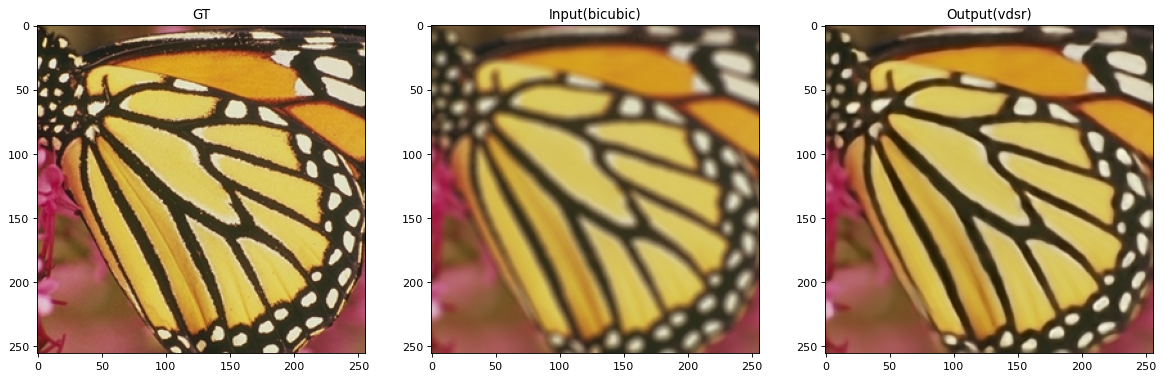

(14.497704102267317, 13.398088752054294)

In [24]:
display_PSNR(im_gt, im_b2, model)

# convert sample videos

In [300]:
infile = "/media/SSD/superres/super8/super8_best_from_mp2.mp4"
outfile = "/media/SSD/superres/super8test5.mp4"
error_file = "/media/SSD/superres/error.txt"

In [301]:
superres_mp4(infile, outfile, model, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

  0%|          | 0/7195 [00:00<?, ?it/s]

Original File: /media/SSD/superres/super8/super8_best_from_mp2.mp4
frames= 7195 
width= 720 
height= 480 
fps= 59.94005994005994

Process File: /media/SSD/superres/super8test5.mp4
factor: 1.0 
width= 720 
height= 480 
bitrate= 4000k


100%|██████████| 7195/7195 [08:41<00:00, 13.79it/s]


True

In [302]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = "/media/SSD/superres/muffins30sectest5-16.mp4"
superres_mp4(infile, outfile, model, factor=1.6,display=False,bitrate= "4000k")

  0%|          | 3/900 [00:00<00:42, 21.18it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/muffins30sectest5-16.mp4
factor: 1.6 
width= 512 
height= 384 
bitrate= 4000k


100%|██████████| 900/900 [00:39<00:00, 22.56it/s]


True

In [303]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = "/media/SSD/superres/muffins30sectest5-10.mp4"
superres_mp4(infile, outfile, model, factor=1.0,display=False,bitrate= "4000k")

  1%|          | 7/900 [00:00<00:13, 64.41it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/muffins30sectest5-10.mp4
factor: 1.0 
width= 320 
height= 240 
bitrate= 4000k


100%|██████████| 900/900 [00:13<00:00, 66.34it/s]


True

In [25]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = "/media/SSD/superres/muffins30sectest5-20.mp4"
superres_mp4(infile, outfile, model, factor=2.0,display=False,bitrate= "4000k")

  0%|          | 1/900 [00:00<01:34,  9.54it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/muffins30sectest5-20.mp4
factor: 2.0 
width= 640 
height= 480 
bitrate= 4000k


100%|██████████| 900/900 [01:26<00:00, 10.38it/s]


True

In [27]:
infile = "/media/SSD/superres/1987 first video making muffins.mp4"
outfile = "/media/SSD/superres/muffinsfull5-30.mp4"
superres_mp4(infile, outfile, model, factor=3.0,display=False,bitrate= "4000k")


  0%|          | 1/50060 [00:00<1:52:43,  7.40it/s]

Original File: /media/SSD/superres/1987 first video making muffins.mp4
frames= 50060 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/muffinsfull5-30.mp4
factor: 3.0 
width= 960 
height= 720 
bitrate= 4000k


100%|██████████| 50060/50060 [1:04:15<00:00, 12.98it/s]


True

In [39]:
# double scale for video x3 2 min
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -t 120 -filter_complex "[0:v] scale=iw*2:ih*2, pad=2*iw:ih [left]; [1:v] scale=iw/1.5:ih/1.5 [right]; [left][right] overlay=main_w/2:0" -b:v 4000k Outputx2.mp4

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

[libx264 @ 0x5618c7412880] using SAR=1/1
[libx264 @ 0x5618c7412880] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x5618c7412880] profile High, level 3.1
[libx264 @ 0x5618c7412880] 264 - core 152 - H.264/MPEG-4 AVC codec - Copyleft 2003-2017 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=15 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=abr mbtree=1 bitrate=4000 ratetol=1.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to 'Outputx2.mp4':
  Metadata:
    major_brand     : isom
    minor_version   : 512
    compatible_bra

In [ ]:
# original scale , for video x3
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v] scale=iw*1:ih*1, pad=2*iw:ih [left]; [1:v] scale=iw/3:ih/3 [right]; [left][right] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [54]:
infile = "/media/SSD/superres/super8/super8_best_from_mp2.mp4"
outfile = "/media/SSD/superres/super8test.mp4"
dualfile= "/media/SSD/superres/super8testdual.mp4"

In [55]:
# original scale , for film x1
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v] scale=iw*1:ih*1, pad=2*iw:ih [left]; [1:v] scale=iw/1:ih/1 [right]; [left][right] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [47]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [ ]:
from multiprocessing.pool import ThreadPool
from collections import deque


def superres_parallel_mp4(infile, outfile, model, factor=1.0,display=True,bitrate= "12000k",errorfile = None):

    class DummyTask:
        def __init__(self, data):
            self.data = data
        def ready(self):
            return True
        def get(self):
            return self.data





    
    
    model = model.cpu()
    #torch.set_grad_enabled(False)
    #model.eval()
    
    cap = cv2.VideoCapture(str(infile))
    
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps    = cap.get(cv2.CAP_PROP_FPS)
    
    success_flag = False
    
    print("Original File:", str(infile))
    print("frames=",length,"\nwidth=",width,"\nheight=",height,"\nfps=",fps)
    
    

    new_height = int(height*factor)
    new_width = int(width*factor)
    
    print("\nProcess File:", str(outfile))
    print("factor:",factor,"\nwidth=",new_width, "\nheight=",new_height,"\nbitrate=",bitrate)
    
    

    dimension = '{}x{}'.format(new_width, new_height)  #ffmpeg uses bicubic as default scaling alg
    f_format = 'bgr24' # remember OpenCV uses bgr format




    command = ['ffmpeg',
            '-y',
            '-f', 'rawvideo',
            '-vcodec','rawvideo',
            '-s', dimension,
            '-pix_fmt', 'bgr24',
            '-r', str(fps),
            '-i', '-',
            '-i', str(infile),
            '-c:v', 'h264',
            '-c:a', 'aac',
torc
            '-map','0:v:0',
            '-map','1:a:0',
            '-shortest',
            '-b:v', bitrate, 
            str(outfile) ]


    if errorfile is not None:
        ef = open(error_file,"w+")
        p = sp.Popen(command, stdin=sp.PIPE, stderr=ef)
    else:
        p = sp.Popen(command, stdin=sp.PIPE)   
    
    
 
    def process_frame(frame, t0):
        
        if (factor != 1.0):
            frame = cv2.resize(frame, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
        im_b_ycbcr = cv2.cvtColor(frame, cv2.COLOR_BGR2YCR_CB)
        im_b_y = im_b_ycbcr[:,:,0].astype(float)
        im_input = im_b_y/255.
        im_input = Variable(torch.from_numpy(im_input).float()).view(1, -1, im_input.shape[0], im_input.shape[1])
        #im_input = im_input.cuda()
        out = model(im_input)

        #out = out.cpu()
        im_h_y = out.data[0].numpy().astype(np.float32)
        im_h_y = im_h_y * 255.
        im_h_y[im_h_y < 0] = 0
        im_h_y[im_h_y > 255.] = 255.
        im_h_y = im_h_y[0,:,:]

        im_h = colorize(im_h_y, im_b_ycbcr)        
        
        
        return im_h, t0

    
    
    
    threadn = cv2.getNumberOfCPUs()
    pool = ThreadPool(processes = threadn)
    pending = deque()

    threaded_mode = True

    
    while True:
        while len(pending) > 0 and pending[0].ready():
            res, t0 = pending.popleft().get()
            p.stdin.write(res.tobytes())
            
            
            cv2.imshow('threaded video', res)
        if len(pending) < threadn:
            _ret, frame = cap.read()
            t = 0
            
            last_frame_time = t
            if threaded_mode:
                task = pool.apply_async(process_frame, (frame.copy(), t))
            else:
                task = DummyTask(process_frame(frame, t))
            pending.append(task)
        ch = cv2.waitKey(1)
        if ch == ord(' '):
            threaded_mode = not threaded_mode
        if ch == 27:
            break

    print('Done')
    
    p.stdin.close()
    p.wait()

    cap.release()

    # Closes all the frames
    cv2.destroyAllWindows()



In [ ]:
superres_parallel_mp4(infile, outfile, model, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

In [ ]:
model

In [ ]:
infolder = Path("to_do_videos")
outfolder = Path("undistorted_videos")
completefolder = Path("raw_videos")

outfolder.mkdir(exist_ok=True)
completefolder.mkdir(exist_ok=True)


In [ ]:
for filename in infolder.iterdir():
    

    undistort_outfile = outfolder/("undistort"+filename.name)
    
    retval = undistort_mp4(infile=filename, outfile=undistort_outfile,
                           intrinsic_matrix=im, distortion_coefficients=dc,
                           crop=True,display=False,bitrate= "12000k",errorfile = None)   
    
    if retval:
        #move the source file if successful
        completefile = completefolder/filename.name
        filename.rename(completefile)